In [2]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as sm
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
import time

In [88]:
pd.set_option('display.max_columns', 500)

In [1]:
import time
def timeit(method):
    '''A time decorator to time other functions.'''
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print ('%r  %2.2f ms' %(method.__name__, (te - ts) * 1000))
        return result
    return timed

In [2]:
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def append_obj(obj,name):
    with open('obj/'+ name + '.pkl', 'ab') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    if name.endswith('.pkl'):
        with open('obj/' + name, 'rb') as f:
            return pickle.load(f)
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Train&Predict Class

Class that reads in a cleaned df a set of xCols and a target feature. Has methods for MSE, MAE and Variance

In [1]:
class LinearTrainPredict:
    
    def __init__ (self, df, xCol, y, name=""):
        self.df = df
        self.xCol = xCol
        self.y = y
        self.__split = int(self.df.shape[0]*0.7)
        self.__X = pd.get_dummies(self.df[self.Xcol],drop_first=True)
        self.__xTrain, self.__xTest = self.__X[:self.__split], self.__X[self.__split:]
        self.__yTrain, self.__yTest = self.df[self.y][:self.__split], self.df[self.y][self.__split:]
        self.__regr = linear_model.LinearRegression()
        if name == ""
            pass
        else:
            with open('obj/'+ name + '.pkl', 'wb') as f:
                pickle.dump(self.__regr, f, pickle.HIGHEST_PROTOCOL)
        self.__regr.fit(self.__xTrain, self.__yTrain)
        self.yPred = self.__regr.predict(self.__xTest)
        
    def mSqErr(self):
        return mean_squared_error(self.__yTest,self.yPred)
        
    def mAbsErr(self):
        return mean_absolute_error(self.__yTest,self.yPred)
    
    def varScore(self):
        return r2_score(self.__yTest,self.yPred)

## Cleaning Dfs

Some fucntions that clean dfs and adds features such as weekday and month integers

In [3]:
#def dateManipulations(df, dateCol, arrCol, m=False, d=False, weekendSplit=False):
def dateManipulations(df, d=False, weekendSplit=False):
    
    
    # ? Duplicate with the weatherInfo function here...
    #df.dateCol = df.dateCol.astype('datetime64[ns]')
    #df['datetime'] = df.dateCol + pd.to_timedelta(df.arrCol, unit = 's')
    # ?
    
    '''
    #We don't use month as a feature anymore, this block can be deleted.
    
    #if m == False:
    #Suggest change to:
    if not m:
        pass
    
    #Suggest change to:
    elif m:
    #elif m == True:
        df['month'] = df.dateCol.map(lambda x: x.month)
    else:
        return 'Error in month input, must be True or False!'
    
    
    #same as above.
    #if d == False:
    if not d:
        pass
    
    #elif d == True:
    elif d:
        df['weekday'] = df.dateCol.dt.dayofweek
    else:
        return 'Error in day input, must be True or False!'
    '''
    #suggest change to:
    if weekendSplit and d:
    #if weekendSplit == True && d == True:
        
        #df['m2f'] = np.where((df.weekday ==0) & (df.weekday ==1) & (df.weekday ==2) & (df.weekday ==3) & (df.weekday ==4),1,0)
        #Suggest change to:
        df['m2f'] = np.where(df.weekday <= 4, 1,0)
        df['sat'] = np.where((df.weekday == 5),1,0)
        
    #same above
    elif not weekendSplit:
    #elif weekendSplit == False:
        pass
    #elif weekendSplit == True && d == False:
    elif weekendSplit and not d:
        return 'Error, must have weekday column for weekend split'
    else:
        return 'Error in weekend split input, must be True or False!'
    return df

In [4]:
def addPeakHours(df, timeOfDayCol):
    df['em'] = np.where((df[timeOfDayCol] > 14400) & (df[timeOfDayCol] <=  25200),1,0)
    df['mp'] = np.where((df[timeOfDayCol] > 25200) & (df[timeOfDayCol] <=  36000),1,0)
    df['lm'] = np.where((df[timeOfDayCol] > 36000) & (df[timeOfDayCol] <=  46800),1,0)
    df['md'] = np.where((df[timeOfDayCol] > 46800) & (df[timeOfDayCol] <=  47600),1,0)
    df['ap'] = np.where((df[timeOfDayCol] > 47600) & (df[timeOfDayCol] <=  68400),1,0)
    df['ev'] = np.where((df[timeOfDayCol] > 68400) & (df[timeOfDayCol] <=  79200),1,0)
    df['ln'] = np.where((df[timeOfDayCol] > 79200) & (df[timeOfDayCol] <=  90000),1,0)
    return df

In [49]:
def addStartTime(df):
    '''This function will take a dataframe, extract the start time of each trip then append it to  each row.'''
    
    startTime = df.loc[df.progrnumber == 1]
    startTime = startTime.drop(['progrnumber', 'stopid', 'plannedtime','actual_arr', 'datetime', 'weekday', 'rain', 'temp'],1)
    startTime.columns = ['dayofservice','tripid','tripStart']
    result = pd.merge(df,startTime,on=['dayofservice','tripid'])
    #print("result columns:",result.columns)
    result['tripTravelTime'] = result.actual_arr - result.tripStart
    result = result.loc[result.tripTravelTime > 0]
    return result

### Weather Function
Basic function that reads in the weather csv, formats it and merges it with supplied data, returning the merged datframe

### I cleaned this function a little bit. -Wang

In [63]:
weather = pd.read_csv('CleanedWeather2016_17C.csv')
weather.head()

,datetime,rain,temp
0,2016-01-01 00:00:00,0.0,1.2
1,2016-01-01 01:00:00,0.0,1.5
2,2016-01-01 02:00:00,0.0,-0.2
3,2016-01-01 03:00:00,0.0,-0.7
4,2016-01-01 04:00:00,0.0,-0.3


In [64]:
weather.datetime.dtype

dtype('O')

In [6]:
def weatherInfo(data):
    '''Add weather information (temp, precipitation) to the dataframe.'''
    
    weather = pd.read_csv('CleanedWeather2016_17C.csv')#,index_col=0)
    weather.datetime = weather.datetime.astype('datetime64[ns]')
    
    data.dayofservice = data.dayofservice.astype('datetime64[ns]')
    data['datetime'] = data.dayofservice + pd.to_timedelta(data.actual_arr,unit='s')
    data['weekday'] = data.dayofservice.dt.dayofweek
    data = data.sort_values('datetime')
    #data = data.reset_index()
    data[['tripid','progrnumber']] = data[['tripid','progrnumber']].astype('int')
    df = pd.merge_asof(data,weather,on='datetime',tolerance=pd.Timedelta('1h'))
    
    return df

In [7]:
def addUCDTerm(df):
    '''Add historical UCD Term for first half years of 2016 and 2017.'''
    df['ucdSchoolTerm'] = np.where(((df['dayofservice'] >= '2016-01-25') & (df['dayofservice'] <= '2016-04-29'))
                                     | ((df['dayofservice'] >= '2016-05-09') & (df['dayofservice'] <= '2016-05-21'))
                                     | ((df['dayofservice'] >= '2017-01-23') & (df['dayofservice'] <= '2016-04-28'))
                                     | ((df['dayofservice'] >= '2016-05-08') & (df['dayofservice'] <= '2016-05-19'))
                                     ,1,0)
    return df

In [46]:
'102_10l'.split('_')

['102', '10l']

In [53]:
import fnmatch, os
for file in os.listdir('obj/stopDicts/'):
    #print(file)
    if fnmatch.fnmatch(file, '39A_767_7162_*'):
        print(file)

39A_767_7162_Ongar.pkl


In [77]:
import fnmatch, os
import numpy as np
import pandas as pd
@timeit
def dataPreparation(file):
    '''
    Prepare the data and return the prepared dataframe.
    Will have columns:
    ['progrnumber','plannedtime','rain','weekday','shape_dist_traveled','em','mp','lm','md','ap','ev','ln','temp','m2f','sat',
    'ucdSchoolTerm']
    '''
    try:
        df = pd.read_csv(file,names=['dayofservice','tripid','progrnumber','stopid','plannedtime','actual_arr','actual_dep'])
        
    except ParserError:
        df = pd.read_csv(file,names=['dayofservice','tripid','progrnumber','stopid','plannedtime','actual_arr','actual_dep'],
                         engine='python')
        
    #print("Read in:",df.columns)
    
    line = str(file.split('/')[-1].split('_')[0])
    #print("Line:",line)
    if not df.loc[df.progrnumber == 1].empty:
        startStop = str(df.loc[df.progrnumber == 1,'stopid'].values[0])
        #print("startStop:",startStop)
        
        #dfMerged.loc[dfMerged.progrnumber.idxmax(),'stopid']
        endStop = str(df.loc[df.progrnumber.idxmax(),'stopid'])
        #print("endStop:",endStop)
        
        identifier = (line, startStop, endStop)
        
        if not os.path.isfile('obj/scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler.pkl') or \
        not os.path.isfile('obj/models/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_model.pkl'): 

            #add weather and initial cleaning.
            df = weatherInfo(df)

            #print("After weatherInfo:",df.columns)
            #add start time
            df = addStartTime(df)

            #add distance
            #read in specific pkl in
            for file in os.listdir('obj/stopDicts/'):
            #print(file)
                if fnmatch.fnmatch(file, line+'_'+startStop+'_'+ endStop+ '_*'):
                    disDict = load_obj('stopDicts/'+file)
                    disdf = pd.DataFrame.from_dict(disDict,orient='index',columns=['distance'])
                    df = pd.merge(df,disdf,left_on=['stopid'],right_index=True)


                    #add period
                    df = addPeakHours(df,'actual_arr')

                    #add weekday
                    df = dateManipulations(df,True,True)

                    #add UCD Term
                    df = addUCDTerm(df)

                    return df, identifier

In [87]:
testdf = dataPreparation('Test/leavetimes/39A_41l')
testdf.head()

'dataPreparation'  1240.78 ms


,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
0,2016-01-09,2784381,1,767,83700,83586,83586,2016-01-09 23:13:06,5,4.4,...,0,0,0,0,0,0,1,0,1,0
25,2016-01-09,2784382,1,767,84600,84561,84561,2016-01-09 23:29:21,5,4.4,...,0,0,0,0,0,0,1,0,1,0
49,2016-01-16,2784381,1,767,83700,83392,83392,2016-01-16 23:09:52,5,0.1,...,0,0,0,0,0,0,1,0,1,0
50,2016-01-16,2784382,1,767,84600,84570,84570,2016-01-16 23:29:30,5,0.1,...,0,0,0,0,0,0,1,0,1,0
75,2016-01-23,2784381,1,767,83700,83685,83685,2016-01-23 23:14:45,5,0.0,...,0,0,0,0,0,0,1,0,1,0


In [51]:
testDict = load_obj('stopDicts/39A_767_328_Aston Quay')
testDict

{767: 0.0,
 768: 657.287066064875,
 769: 985.330520927881,
 770: 1429.24894221461,
 771: 1620.44696377974,
 772: 2127.48709498295,
 773: 3434.8578642479997,
 774: 3677.18821727873,
 775: 4001.74363072419,
 776: 4285.13185337461,
 777: 4493.83259606615,
 779: 4740.48732233394,
 780: 5009.04830237385,
 781: 5193.6587029476,
 782: 5357.09815442135,
 783: 5606.069766801032,
 784: 5776.637949866071,
 785: 6055.606335357479,
 786: 6545.589502681712,
 793: 7269.64182312836,
 7586: 7835.15763393275,
 7587: 8467.10980025078,
 7588: 8530.04627616102,
 328: 9243.322928124291}

In [90]:
testdf

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,temp,tripStart,tripTravelTime,distance,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
0,2016-01-09,2784381,1,767,83700,83586,83586,2016-01-09 23:13:06,5,4.4,3.0,83586,0,0.000000,0,0,0,0,0,0,1,0,1,0
25,2016-01-09,2784382,1,767,84600,84561,84561,2016-01-09 23:29:21,5,4.4,3.0,84561,0,0.000000,0,0,0,0,0,0,1,0,1,0
49,2016-01-16,2784381,1,767,83700,83392,83392,2016-01-16 23:09:52,5,0.1,4.8,83392,0,0.000000,0,0,0,0,0,0,1,0,1,0
50,2016-01-16,2784382,1,767,84600,84570,84570,2016-01-16 23:29:30,5,0.1,4.8,84570,0,0.000000,0,0,0,0,0,0,1,0,1,0
75,2016-01-23,2784381,1,767,83700,83685,83685,2016-01-23 23:14:45,5,0.0,12.4,83685,0,0.000000,0,0,0,0,0,0,1,0,1,0
100,2016-01-30,2784381,1,767,83700,83635,83635,2016-01-30 23:13:55,5,0.0,2.8,83635,0,0.000000,0,0,0,0,0,0,1,0,1,1
125,2016-01-30,2784382,1,767,84600,84553,84553,2016-01-30 23:29:13,5,0.0,2.8,84553,0,0.000000,0,0,0,0,0,0,1,0,1,1
149,2016-02-02,2818069,1,767,84600,84613,84613,2016-02-02 23:30:13,1,0.0,1.9,84613,0,0.000000,0,0,0,0,0,0,1,1,0,1
170,2016-02-05,2818069,1,767,84600,84616,84616,2016-02-05 23:30:16,4,0.0,3.4,84616,0,0.000000,0,0,0,0,0,0,1,1,0,1
192,2016-02-06,2822742,1,767,83700,83683,83683,2016-02-06 23:14:43,5,0.0,3.7,83683,0,0.000000,0,0,0,0,0,0,1,0,1,1


In [53]:
testdf.loc[testdf.distance.isnull()]

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm


## Route Manipulation functions

Functions that uses stop_times.txt to generate features and a route Dictionary that will be used with model prediction

# <font color='red'> Only run it once</font>

In [8]:
#Some of the work is once off, I suggest do it once not do it everytime we load in the txt.
import pandas as pd
stoptime = pd.read_csv('stop_times.txt')
#Only look at the rows for certain route.
stoptime['line'] = stoptime.trip_id.str.split('-').str[1]
stoptime = stoptime[stoptime.stop_id.str.contains(':') == False]
stoptime['stopid'] = stoptime.stop_id.str.slice(8,)
stoptime.stopid = stoptime['stopid'].astype('int64')
stoptime.to_csv('stop_timesC',index=False)

In [10]:
stoptime = pd.read_csv('stop_timesC')
#stoptime.dtypes
stoptime.head()

/home/student/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,line,stopid
0,3643.y102m.60-1-d12-1.1.O,15:40:00,15:40:00,8240DB000226,1,Sandymount,0,0,0.000000,1,226
1,3643.y102m.60-1-d12-1.1.O,15:40:47,15:40:47,8240DB000228,2,Sandymount,0,0,261.136188,1,228
2,3643.y102m.60-1-d12-1.1.O,15:41:26,15:41:26,8240DB000229,3,Sandymount,0,0,484.925289,1,229
3,3643.y102m.60-1-d12-1.1.O,15:42:30,15:42:30,8240DB000227,4,Sandymount,0,0,836.995679,1,227
4,3643.y102m.60-1-d12-1.1.O,15:43:09,15:43:09,8240DB000230,5,Sandymount,0,0,1066.461783,1,230


In [11]:
stoptime['tripmark'] = stoptime.trip_id.str.split('.').str[3]
stoptime.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,line,stopid,tripmark
0,3643.y102m.60-1-d12-1.1.O,15:40:00,15:40:00,8240DB000226,1,Sandymount,0,0,0.000000,1,226,1
1,3643.y102m.60-1-d12-1.1.O,15:40:47,15:40:47,8240DB000228,2,Sandymount,0,0,261.136188,1,228,1
2,3643.y102m.60-1-d12-1.1.O,15:41:26,15:41:26,8240DB000229,3,Sandymount,0,0,484.925289,1,229,1
3,3643.y102m.60-1-d12-1.1.O,15:42:30,15:42:30,8240DB000227,4,Sandymount,0,0,836.995679,1,227,1
4,3643.y102m.60-1-d12-1.1.O,15:43:09,15:43:09,8240DB000230,5,Sandymount,0,0,1066.461783,1,230,1


In [14]:
stoptime[['stop_sequence','stop_headsign','shape_dist_traveled','line','stopid','tripmark']].drop_duplicates().to_csv('stop_timeCC',index=False)

In [ ]:
'''
I notice a situation that you cannot just use get unique to get all the unique route. This is because there are more than one
route for a bus line + direction. E.g.:
39aO has three combination, 
1. start from UCD(767), go to Ongar
2. start from UCD(767), go to Aston
3. start from Aston(328), go to Ongar.
Base on this kind of situation, I suggest we name route as 39a_767_7162_Ongar (busline+startstopid+endstopid+destinationStop).
This will guarantee we have all the routes and it would be clean and without dupilication.
'''

In [30]:
d = load_obj('stopDicts/39A_767_ Ongar')
d

{767: 0.0,
 768: 657.287066064875,
 769: 985.330520927881,
 770: 1429.24894221461,
 771: 1620.44696377974,
 772: 2127.48709498295,
 773: 3434.8578642479997,
 774: 3677.18821727873,
 775: 4001.74363072419,
 776: 4285.13185337461,
 777: 4493.83259606615,
 779: 4740.48732233394,
 780: 5009.04830237385,
 781: 5193.6587029476,
 782: 5357.09815442135,
 783: 5606.069766801032,
 784: 5776.637949866071,
 785: 6055.606335357479,
 786: 6545.589502681712,
 793: 7269.64182312836,
 7586: 7835.15763393275,
 7587: 8467.10980025078,
 7588: 8530.04627616102,
 328: 9243.322928124291,
 1443: 9826.568859010358,
 1444: 10107.2418629801,
 1445: 10417.1497368751,
 1647: 10939.5178555804,
 1648: 11272.5213698264,
 1649: 11469.3056185517,
 1911: 11995.4996735001,
 1913: 12337.7290265695,
 1914: 12592.8159362723,
 1805: 12806.0519246444,
 1806: 13196.947965981299,
 1660: 13713.2410577792,
 1661: 13997.7195279663,
 1662: 14322.374320031799,
 1664: 14788.0353517777,
 1665: 15079.2139210518,
 1666: 15297.9786348426

In [59]:
pd.DataFrame.from_dict(d,orient='index',columns=['distance'])

,distance
767,0.000000
768,657.287066
769,985.330521
770,1429.248942
771,1620.446964
772,2127.487095
773,3434.857864
774,3677.188217
775,4001.743631
776,4285.131853


In [47]:
#Based on the discussion above, I changed this function into a function that run once and split all the routes into pickle file
# for later consideration:
#https://stackoverflow.com/questions/16497115/python-pickle-vs-sql-efficiency
#security issue? efficiency issue?...
@timeit
def getStops(file):
    
    '''get stops for a certain route from GTFS file.'''
    
    stoptime = pd.read_csv(file)
    '''
    #stoptime['line'] = stoptime.trip_id.str.split('-').str[1]
    #stoptime = stoptime[stoptime.stop_id.str.contains(':') == False]
    #stoptime['stopid'] = stoptime.stop_id.str.slice(8,)
    #stoptime.stopid = stoptime['stopid'].astype('int64')
    
    if outbound == True:
        routeDf = stoptime.loc[(stoptime.line == route) & (stoptime.trip_id.str.split('.').str[4]=='O')]
    elif outbound == False:
        routeDf = stoptime.loc[(stoptime.line == route) & (stoptime.trip_id.str.split('.').str[4]=='I')]
    else:
        return 'Error outbound must be True or False!'
    
    #Now there are many duplicate in the df, get unique.
    
    return routeDf[['stop_sequence','shape_dist_traveled', 'stopid']]
    
    header = ['stop_sequence','stop_headsign','shape_dist_traveled','line','stopid','tripmark']
    '''
    for line in stoptime.line.unique():
        for tm in stoptime.tripmark.unique():
            df = stoptime.loc[(stoptime.line == line) & (stoptime.tripmark == tm)]
            #print(df)
            if not df.empty and not df.loc[df.stop_sequence==1,'stopid'].empty:
                #IndexError: index 0 is out of bounds for axis 0 with size 0
                start = str(df.loc[df.stop_sequence==1,'stopid'].values[0]).strip()
                dest = str(df.loc[df.stop_sequence==1,'stop_headsign'].values[0]).strip()
                end = str(df.loc[df.stop_sequence.idxmax(),'stopid']).strip()
                save_obj(df[['stopid','shape_dist_traveled']].set_index('stopid')['shape_dist_traveled'].to_dict(), \
                         'stopDicts/'+str(line)+'_'+start+'_'+ end +'_'+ dest)

In [48]:
getStops('stop_timeCC')

'getStops'  349834.00 ms


# <font color='red'> Only run it once END</font>

In [7]:
def createStopDict(routeDf, name):
    stops = routeDf[['stop_sequence','stopid']]
    stops = stops.reset_index(drop = True)
    stops = stops.sort_values('stop_sequence')
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(stops.stopid.tolist(), f, pickle.HIGHEST_PROTOCOL)
    return

In [3]:
def checkstopSeq(routeDf):
    if routeDf.stopSeq.iloc[0] != 1:
        print('Starting stop is not 1')
        return False
    else:
        for i in routeDf.stopSeq:
            if routeDf.stopSeq.iloc[i+1] - routeDf.stopSeq.iloc[i] == 1:
                pass
                if routeDf.stopSeq.iloc[i+1] == routeDf.stopSeq.iloc[-1]:
                    break
            else:
                return False
            if routeDf.stopSeq.is_monotonic_increasing == True:
                return True
            elif routeDf.stopSeq.is_monotonic_increasing == False:
                return False
            else:
                return 'Error in monotonic method'

In [ ]:
#Now we have the dictionary pickle that contains stopid and distance, we can use this to add features.


# The functions for data preparation is ready above, time to build functions to train models. :)

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import os
@timeit
def prepareAndTrain(df, identifier, Xcol=['progrnumber','plannedtime','rain','weekday','distance','em','mp','lm','md','ap','ev',
                                          'ln','temp','m2f','sat','ucdSchoolTerm'], y='tripTravelTime', split=0.7):
    '''
    This function will take a dataframe, Prepare it for a neural network model.
    Export scaler file for later use.
    Xcol: A list of columns to train model
    y: target feature
    split: split percentage. By default 0.7/0.3
    train neural network model
    evaluate it.
    '''
    if not os.path.isfile('obj/scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler.pkl') or \
    not os.path.isfile('obj/models/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_model.pkl'): 
        #df.sample(frac=1)
        df = df.loc[df.tripTravelTime > 0].sample(frac=1)
        X = df[Xcol]
        split = int(df.shape[0]*split)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = df[y][:split], df[y][split:]
        scaler = StandardScaler() 
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        regr = MLPRegressor()
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)
        print('MAE:',mean_absolute_error(y_test, y_pred))

        if mean_absolute_error(y_test, y_pred) <= 300:
            #if not os.path.isfile('obj/scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler'): 
            #Model's MAE smaller than 5mins

            #How to name it?
            save_obj(scaler,'scalers/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_scaler')
            save_obj(regr,'models/'+identifier[0]+'_'+identifier[1]+'_'+identifier[2]+'_model')
        else:
            log = ":(((( Unqualified route:"+str(identifier)
            print(log)
            append_obj(identifier,'unqualifiedlog')

In [64]:
not os.path.isfile('obj/scalers/111_3057_4983_scaler.pkl') and \
not os.path.isfile('obj/models/111_3057_4983_model.pkl')

False

In [55]:
testdf, id = dataPreparation('Test/leavetimes/39A_40l')

'dataPreparation'  268912.01 ms


In [56]:
testdf

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep,datetime,weekday,rain,...,em,mp,lm,md,ap,ev,ln,m2f,sat,ucdSchoolTerm
1,2016-01-09,2784478,2,768,23543,23486,23486,2016-01-09 06:31:26,5,0.0,...,1,0,0,0,0,0,0,0,1,0
74,2016-01-09,2784522,2,768,24443,24463,24479,2016-01-09 06:47:43,5,0.0,...,1,0,0,0,0,0,0,0,1,0
147,2016-01-09,2784527,2,768,25304,25293,25293,2016-01-09 07:01:33,5,0.4,...,0,1,0,0,0,0,0,0,1,0
220,2016-01-09,2784397,2,768,27104,26804,26814,2016-01-09 07:26:44,5,0.4,...,0,1,0,0,0,0,0,0,1,0
293,2016-01-09,2784404,2,768,28004,28089,28089,2016-01-09 07:48:09,5,0.4,...,0,1,0,0,0,0,0,0,1,0
366,2016-01-09,2784532,2,768,28925,28892,28892,2016-01-09 08:01:32,5,1.1,...,0,1,0,0,0,0,0,0,1,0
438,2016-01-09,2784574,2,768,29825,29826,29826,2016-01-09 08:17:06,5,1.1,...,0,1,0,0,0,0,0,0,1,0
511,2016-01-09,2784542,2,768,30725,30697,30697,2016-01-09 08:31:37,5,1.1,...,0,1,0,0,0,0,0,0,1,0
584,2016-01-09,2784547,2,768,31625,31726,31746,2016-01-09 08:48:46,5,1.1,...,0,1,0,0,0,0,0,0,1,0
657,2016-01-09,2784521,2,768,33404,33453,33490,2016-01-09 09:17:33,5,0.5,...,0,1,0,0,0,0,0,0,1,0


In [58]:
#testdf, id = dataPreparation('Test/leavetimes/39A_40l')
prepareAndTrain(testdf,id)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 240.34984012433424
'prepareAndTrain'  1513999.53 ms


In [29]:
Xcol=['progrnumber','plannedtime','rain','weekday','distance','em','mp','lm','md','ap','ev', 'ln','temp','m2f','sat',
      'ucdSchoolTerm']
y='tripTravelTime'

In [43]:
X = testdf[Xcol].sample(frac=1)
X

,progrnumber,plannedtime,rain,weekday,distance,em,mp,lm,md,ap,ev,ln,temp,m2f,sat,ucdSchoolTerm
26393,13,37837,0.0,1,5009.048302,0,0,1,0,0,0,0,4.5,1,0,1
540219,39,74770,0.0,3,14322.374320,0,0,0,0,0,1,0,13.1,1,0,1
422033,50,53512,0.0,0,21728.606084,0,0,0,0,1,0,0,12.0,1,0,1
534326,71,70595,0.0,2,29493.627107,0,0,0,0,0,1,0,13.0,1,0,1
111811,34,84763,0.0,3,12592.815936,0,0,0,0,0,0,1,3.2,1,0,1
725091,53,63239,0.0,3,22612.487965,0,0,0,0,1,0,0,14.7,1,0,0
800076,18,58590,0.0,3,6055.606335,0,0,0,0,1,0,0,4.0,1,0,0
256093,41,55741,0.0,0,15079.213921,0,0,0,0,1,0,0,8.3,1,0,1
652309,46,53295,0.0,2,18513.615713,0,0,0,0,1,0,0,17.8,1,0,0
396702,16,27549,0.0,2,5606.069767,0,1,0,0,0,0,0,7.5,1,0,1


In [44]:
split = int(testdf.shape[0]*0.9)
print(split)

1018693


In [45]:
X_train, X_test = X[:split], X[split:]
y_train, y_test = testdf[y][:split], testdf[y][split:]
scaler = StandardScaler() 
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-1.13367681, -1.06341828, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       [ 0.10111343,  1.27308502, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       [ 0.62352468, -0.07176612, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927],
       ...,
       [ 0.57603275,  0.43440351, -0.18780125, ..., -2.09779411,
        -0.35786274,  1.13505927],
       [ 0.00612956,  0.51727843, -0.18780125, ...,  0.47669121,
        -0.35786274, -0.88101126],
       [ 1.2409198 , -1.02729494, -0.18780125, ...,  0.47669121,
        -0.35786274,  1.13505927]])

In [ ]:
regr = MLPRegressor()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print('MAE:',mean_absolute_error(y_test, y_pred))

In [36]:
import seaborn as sns
def plotPred(y_pred,y_test):
    plot = sns.kdeplot( y_pred , color="skyblue", label="Prediction")
    plot = sns.kdeplot( y_test , color="red", label="Actual")

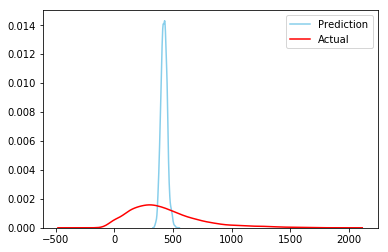

In [38]:
plotPred(regr.predict(X_train),y_train)

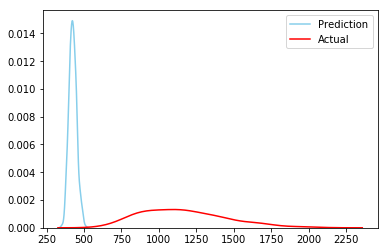

In [37]:
plotPred(y_pred,y_test)

In [78]:
os.listdir('Test/leavetimes/')

['27_19l',
 '33_69l',
 '25B_271l',
 '79A_27l',
 '40_32l',
 '33_17l',
 '17A_14l',
 '63_24l',
 '39_20l',
 '111_10l',
 '.ipynb_checkpoints',
 '151_16l',
 '7_71l',
 '76_36l',
 '39A_42l',
 '45A_68l',
 '7A_87l',
 '16C_28l',
 '13_75l',
 '7B_91l',
 '46A_62l',
 '45A_69l',
 '49_27l',
 '15A_81l',
 '83A_17l',
 '122_17l',
 '63_25l',
 '161_52l',
 '16_21l',
 '66X_99l',
 '32X_75l',
 '1_41l',
 '145_87l',
 '66A_34l',
 '33_73l',
 '111_4l',
 '65_75l',
 '46A_68l',
 '46A_74l',
 '46A_72l',
 '25B_276l',
 '66B_55l',
 '65_76l',
 '79A_28l',
 '31D_50l',
 '83_18l',
 '27_12l',
 '140_20l',
 '40B_65l',
 '77A_29l',
 '102_8l',
 '17_11l',
 '33A_23l',
 '75_21l',
 '33X_46l',
 '114_5l',
 '145_105l',
 '66X_92l',
 '13_72l',
 '40D_101l',
 '43_89l',
 '757_1l',
 '32_57l',
 '44_39l',
 '49_29l',
 '43_88l',
 '16_20l',
 '63_21l',
 '37_15l',
 '31D_51l',
 '40D_104l',
 '76A_29l',
 '69_41l',
 '69X_58l',
 '130_10l',
 '40_26l',
 '41_20l',
 '32X_74l',
 '41C_80l',
 '270_42l',
 '51X_63l',
 '33A_25l',
 '84A_3l',
 '84_27l',
 '46A_69l',
 '27X_

In [89]:
X.columns

Index(['progrnumber', 'plannedtime', 'rain', 'weekday', 'distance', 'em', 'mp',
       'lm', 'md', 'ap', 'ev', 'ln', 'temp', 'm2f', 'sat', 'ucdSchoolTerm'],
      dtype='object')

In [79]:
for file in os.listdir('Test/leavetimes/'):
    if file.endswith('l'):
        print('Preparing data for',file)
        result = dataPreparation('Test/leavetimes/'+ file)
        if result:
            df, id = result[0],result[1]

            print('training data for',id)
            prepareAndTrain(df,id)
        else:
            print('Skipping...')

Preparing data for 27_19l
'dataPreparation'  1635.36 ms
Skipping...
Preparing data for 33_69l
'dataPreparation'  160.85 ms
training data for ('33', '292', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3360.251744286205
:(((( Unqualified route:('33', '292', '3802')
'prepareAndTrain'  266.93 ms
Preparing data for 25B_271l
'dataPreparation'  469.61 ms
Skipping...
Preparing data for 79A_27l
'dataPreparation'  257.14 ms
Skipping...
Preparing data for 40_32l
'dataPreparation'  12.78 ms
Skipping...
Preparing data for 33_17l
'dataPreparation'  45712.57 ms
training data for ('33', '292', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 312.32768077281014
:(((( Unqualified route:('33', '292', '3802')
'prepareAndTrain'  257709.72 ms
Preparing data for 17A_14l
'dataPreparation'  32.33 ms
Skipping...
Preparing data for 63_24l
'dataPreparation'  11.58 ms
Skipping...
Preparing data for 39_20l
'dataPreparation'  628.50 ms
Skipping...
Preparing data for 111_10l
'dataPreparation'  8.12 ms
Skipping...
Preparing data for 151_16l
'dataPreparation'  23821.78 ms
training data for ('151', '7514', '4619')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 155.9656267200974
'prepareAndTrain'  107663.30 ms
Preparing data for 7_71l
'dataPreparation'  12526.84 ms
training data for ('7', '7639', '4')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 118.92537215273998
'prepareAndTrain'  43610.58 ms
Preparing data for 76_36l
'dataPreparation'  60078.75 ms
training data for ('76', '2243', '4341')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 147.51407972568148
'prepareAndTrain'  281412.92 ms
Preparing data for 39A_42l
'dataPreparation'  5648.67 ms
training data for ('39A', '7158', '313')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 83.94715154350897
'prepareAndTrain'  20688.45 ms
Preparing data for 45A_68l
'dataPreparation'  19331.50 ms
training data for ('45A', '2037', '6000')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 177.97093418039546
'prepareAndTrain'  87011.35 ms
Preparing data for 7A_87l
'dataPreparation'  32102.70 ms
training data for ('7A', '3222', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 194.6850923509883
'prepareAndTrain'  153492.94 ms
Preparing data for 16C_28l
'dataPreparation'  4517.29 ms
training data for ('16C', '5171', '7615')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 88.40763937946517
'prepareAndTrain'  13167.05 ms
Preparing data for 13_75l
'dataPreparation'  172.47 ms
training data for ('13', '281', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 833.3381883575594
:(((( Unqualified route:('13', '281', '332')
'prepareAndTrain'  253.81 ms
Preparing data for 7B_91l
'dataPreparation'  8142.18 ms
training data for ('7B', '4962', '3544')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 238.46537869462352
'prepareAndTrain'  33596.11 ms
Preparing data for 46A_62l
'dataPreparation'  722.69 ms
training data for ('46A', '2060', '2')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 660.8347982032195
:(((( Unqualified route:('46A', '2060', '2')
'prepareAndTrain'  2050.36 ms
Preparing data for 45A_69l
'dataPreparation'  3067.78 ms
training data for ('45A', '4533', '4983')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 252.46044040838598
'prepareAndTrain'  10240.03 ms
Preparing data for 49_27l
'dataPreparation'  73958.32 ms
training data for ('49', '342', '7181')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 185.4511987301399
'prepareAndTrain'  343793.51 ms
Preparing data for 15A_81l
'dataPreparation'  8296.04 ms
training data for ('15A', '395', '1104')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 170.80251454139946
'prepareAndTrain'  25248.28 ms
Preparing data for 83A_17l
'dataPreparation'  39301.81 ms
training data for ('83A', '324', '2492')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 223.01061089297048
'prepareAndTrain'  197566.60 ms
Preparing data for 122_17l
'dataPreparation'  1701.22 ms
training data for ('122', '1423', '279')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 74.82872357273943
'prepareAndTrain'  5939.29 ms
Preparing data for 63_25l
'dataPreparation'  5990.40 ms
training data for ('63', '2039', '3283')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 105.60090659520263
'prepareAndTrain'  20671.13 ms
Preparing data for 161_52l
'dataPreparation'  848.01 ms
training data for ('161', '7067', '2825')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 110.9966170104487
'prepareAndTrain'  2085.58 ms
Preparing data for 16_21l
'dataPreparation'  19178.27 ms
training data for ('16', '226', '2975')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 234.47470064152714
'prepareAndTrain'  68970.21 ms
Preparing data for 66X_99l
'dataPreparation'  1715.10 ms
training data for ('66X', '4003', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 665.1520498490494
:(((( Unqualified route:('66X', '4003', '4952')
'prepareAndTrain'  4927.04 ms
Preparing data for 32X_75l
'dataPreparation'  3303.70 ms
training data for ('32X', '4952', '5082')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 581.1170137244771
:(((( Unqualified route:('32X', '4952', '5082')
'prepareAndTrain'  10189.41 ms
Preparing data for 1_41l
'dataPreparation'  8500.65 ms
Skipping...
Preparing data for 145_87l
'dataPreparation'  547.14 ms
training data for ('145', '773', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 450.9809555163941
:(((( Unqualified route:('145', '773', '4320')
'prepareAndTrain'  987.17 ms
Preparing data for 66A_34l
'dataPreparation'  39864.53 ms
training data for ('66A', '7391', '3994')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 197.1092359391882
'prepareAndTrain'  220379.58 ms
Preparing data for 33_73l
'dataPreparation'  149.24 ms
Skipping...
Preparing data for 111_4l
'dataPreparation'  2695.19 ms
Skipping...
Preparing data for 65_75l
'dataPreparation'  21588.46 ms
training data for ('65', '7289', '7564')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 129.81979766124283
'prepareAndTrain'  100184.98 ms
Preparing data for 46A_68l
'dataPreparation'  3491.55 ms
training data for ('46A', '264', '2039')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 202.82062459667685
'prepareAndTrain'  13369.56 ms
Preparing data for 46A_74l
'dataPreparation'  324337.23 ms
training data for ('46A', '807', '2039')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 235.91888396274607
'prepareAndTrain'  2158617.15 ms
Preparing data for 46A_72l
'dataPreparation'  1442.22 ms
training data for ('46A', '4962', '2039')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 525.8676052527024
:(((( Unqualified route:('46A', '4962', '2039')
'prepareAndTrain'  4901.48 ms
Preparing data for 25B_276l
'dataPreparation'  556.30 ms
training data for ('25B', '4619', '7390')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1160.632833106973
:(((( Unqualified route:('25B', '4619', '7390')
'prepareAndTrain'  486.28 ms
Preparing data for 66B_55l
'dataPreparation'  40918.21 ms
training data for ('66B', '7391', '4003')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 185.89973249114055
'prepareAndTrain'  260073.43 ms
Preparing data for 65_76l
'dataPreparation'  6789.77 ms
training data for ('65', '7270', '7564')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 199.8363951981912
'prepareAndTrain'  26571.35 ms
Preparing data for 79A_28l
'dataPreparation'  41413.48 ms
training data for ('79A', '6030', '326')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 96.97478028712214
'prepareAndTrain'  187663.88 ms
Preparing data for 31D_50l
'dataPreparation'  576.87 ms
training data for ('31D', '7571', '913')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 695.1647458986415
:(((( Unqualified route:('31D', '7571', '913')
'prepareAndTrain'  1790.09 ms
Preparing data for 83_18l
'dataPreparation'  1879.29 ms
training data for ('83', '324', '336')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 89.09585743024566
'prepareAndTrain'  6791.64 ms
Preparing data for 27_12l
'dataPreparation'  8567.74 ms
training data for ('27', '395', '2355')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 110.65102487747585
'prepareAndTrain'  29620.15 ms
Preparing data for 140_20l
'dataPreparation'  1299.74 ms
training data for ('140', '7149', '6059')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 82.30308223282424
'prepareAndTrain'  4391.51 ms
Preparing data for 40B_65l
'dataPreparation'  11276.11 ms
training data for ('40B', '4316', '6071')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 147.17245920112669
'prepareAndTrain'  34111.39 ms
Preparing data for 77A_29l
'dataPreparation'  182252.88 ms
training data for ('77A', '395', '7459')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 216.6444387872382
'prepareAndTrain'  742922.11 ms
Preparing data for 102_8l
'dataPreparation'  78839.02 ms
training data for ('102', '4381', '7348')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 129.6866581642792
'prepareAndTrain'  366772.04 ms
Preparing data for 17_11l
'dataPreparation'  4118.29 ms
training data for ('17', '1380', '3085')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 123.60636069403456
'prepareAndTrain'  15863.34 ms
Preparing data for 33A_23l
'dataPreparation'  2214.82 ms
training data for ('33A', '3677', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 162.00633651222591
'prepareAndTrain'  7113.47 ms
Preparing data for 75_21l
'dataPreparation'  1305.15 ms
training data for ('75', '2038', '7181')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 904.9121359093305
:(((( Unqualified route:('75', '2038', '7181')
'prepareAndTrain'  4045.80 ms
Preparing data for 33X_46l
'dataPreparation'  8664.85 ms
training data for ('33X', '407', '7174')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 189.06822384415813
'prepareAndTrain'  34398.15 ms
Preparing data for 114_5l
'dataPreparation'  20865.48 ms
training data for ('114', '6200', '3085')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 131.24186056669404
'prepareAndTrain'  85724.91 ms
Preparing data for 145_105l
'dataPreparation'  302616.61 ms
training data for ('145', '7574', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 208.87300142910144
'prepareAndTrain'  1458256.89 ms
Preparing data for 66X_92l
'dataPreparation'  5803.36 ms
training data for ('66X', '4952', '5114')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 327.5371147999261
:(((( Unqualified route:('66X', '4952', '5114')
'prepareAndTrain'  19068.00 ms
Preparing data for 13_72l
'dataPreparation'  12125.89 ms
training data for ('13', '7229', '6234')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 181.07656078500557
'prepareAndTrain'  51694.90 ms
Preparing data for 40D_101l
'dataPreparation'  27537.35 ms
training data for ('40D', '6004', '7072')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 136.32810784149902
'prepareAndTrain'  90344.15 ms
Preparing data for 43_89l
'dataPreparation'  4421.38 ms
training data for ('43', '4923', '1184')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 147.35975019292857
'prepareAndTrain'  12078.80 ms
Preparing data for 757_1l
'dataPreparation'  7071.98 ms
training data for ('757', '1074', '3665')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 145.97375255884364
'prepareAndTrain'  18151.35 ms
Preparing data for 32_57l
'dataPreparation'  62505.26 ms
training data for ('32', '621', '4387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 180.75183447763115
'prepareAndTrain'  359469.60 ms
Preparing data for 44_39l
'dataPreparation'  185.73 ms
training data for ('44', '265', '4096')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1708.3729289826035
:(((( Unqualified route:('44', '265', '4096')
'prepareAndTrain'  330.64 ms
Preparing data for 49_29l
'dataPreparation'  1956.62 ms
training data for ('49', '2353', '342')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 248.04059620799654
'prepareAndTrain'  4515.83 ms
Preparing data for 43_88l
'dataPreparation'  61748.09 ms
training data for ('43', '5044', '1184')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 134.34556615317052
'prepareAndTrain'  246752.37 ms
Preparing data for 16_20l
'dataPreparation'  242917.93 ms
training data for ('16', '7347', '2975')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 226.1130046987904
'prepareAndTrain'  1180379.48 ms
Preparing data for 63_21l
'dataPreparation'  220.18 ms
Skipping...
Preparing data for 37_15l
'dataPreparation'  146233.51 ms
training data for ('37', '4747', '7340')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 141.5300722196894
'prepareAndTrain'  667052.39 ms
Preparing data for 31D_51l
'dataPreparation'  681.69 ms
training data for ('31D', '928', '7571')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 385.16160594986326
:(((( Unqualified route:('31D', '928', '7571')
'prepareAndTrain'  2088.88 ms
Preparing data for 40D_104l
'dataPreparation'  54761.98 ms
training data for ('40D', '7073', '6071')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 130.7973158774224
'prepareAndTrain'  291760.87 ms
Preparing data for 76A_29l
'dataPreparation'  4523.81 ms
training data for ('76A', '4341', '7026')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 158.11083705742817
'prepareAndTrain'  13512.69 ms
Preparing data for 69_41l
'dataPreparation'  49215.32 ms
Skipping...
Preparing data for 69X_58l
'dataPreparation'  682.18 ms
Skipping...
Preparing data for 130_10l
'dataPreparation'  147991.27 ms
training data for ('130', '7591', '1767')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 111.32315342493554
'prepareAndTrain'  591952.31 ms
Preparing data for 40_26l
'dataPreparation'  2030.91 ms
Skipping...
Preparing data for 41_20l
'dataPreparation'  444.37 ms
training data for ('41', '1174', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1279.3924100901233
:(((( Unqualified route:('41', '1174', '4957')
'prepareAndTrain'  1100.58 ms
Preparing data for 32X_74l
'dataPreparation'  3119.67 ms
training data for ('32X', '3640', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 204.79629387395082
'prepareAndTrain'  10977.39 ms
Preparing data for 41C_80l
'dataPreparation'  13535.27 ms
training data for ('41C', '3088', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 112.59455694733121
'prepareAndTrain'  52922.13 ms
Preparing data for 270_42l
'dataPreparation'  14489.71 ms
training data for ('270', '7026', '3333')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 78.84254694612864
'prepareAndTrain'  60035.94 ms
Preparing data for 51X_63l
'dataPreparation'  2051.56 ms
training data for ('51X', '7433', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 420.0979305443823
:(((( Unqualified route:('51X', '7433', '4953')
'prepareAndTrain'  6268.51 ms
Preparing data for 33A_25l
'dataPreparation'  16184.57 ms
training data for ('33A', '6048', '3692')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 126.02792744543946
'prepareAndTrain'  67452.26 ms
Preparing data for 84A_3l
'dataPreparation'  8059.22 ms
training data for ('84A', '4168', '7188')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 154.46639001640418
'prepareAndTrain'  34447.09 ms
Preparing data for 84_27l
'dataPreparation'  54422.60 ms
training data for ('84', '7188', '4956')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 201.8031833849105
'prepareAndTrain'  250877.87 ms
Preparing data for 46A_69l
'dataPreparation'  1355.33 ms
training data for ('46A', '807', '767')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 196.7210968387467
'prepareAndTrain'  4896.38 ms
Preparing data for 27X_42l
'dataPreparation'  4257.17 ms
training data for ('27X', '4595', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 153.69276226997545
'prepareAndTrain'  12797.81 ms
Preparing data for 39A_41l
'dataPreparation'  1276.51 ms
training data for ('39A', '767', '328')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 123.8270583509812
'prepareAndTrain'  4015.12 ms
Preparing data for 47_137l
'dataPreparation'  1021.56 ms
training data for ('47', '763', '5016')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 329.58319952575283
:(((( Unqualified route:('47', '763', '5016')
'prepareAndTrain'  2590.51 ms
Preparing data for 41_7l
'dataPreparation'  130825.58 ms
training data for ('41', '4843', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 154.64362341228204
'prepareAndTrain'  475555.13 ms
Preparing data for 14C_18l
'dataPreparation'  4450.62 ms
training data for ('14C', '6041', '297')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 85.07699219630702
'prepareAndTrain'  16911.46 ms
Preparing data for 16C_26l
'dataPreparation'  1496.10 ms
training data for ('16C', '208', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 107.0276515735592
'prepareAndTrain'  4268.64 ms
Preparing data for 84A_1l
'dataPreparation'  8525.61 ms
training data for ('84A', '7188', '4168')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 183.15560146092616
'prepareAndTrain'  33690.06 ms
Preparing data for 145_91l
'dataPreparation'  14577.45 ms
training data for ('145', '4202', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 183.05242868784046
'prepareAndTrain'  55398.92 ms
Preparing data for 123_34l
'dataPreparation'  160301.19 ms
training data for ('123', '6057', '1490')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 165.46701718667313
'prepareAndTrain'  856593.99 ms
Preparing data for 33B_59l
'dataPreparation'  1098.82 ms
training data for ('33B', '3732', '3744')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 87.55548832357916
'prepareAndTrain'  3180.23 ms
Preparing data for 185_58l
'dataPreparation'  582.59 ms
training data for ('185', '4108', '4167')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 132.77863648707137
'prepareAndTrain'  1742.96 ms
Preparing data for 76_37l
'dataPreparation'  61420.27 ms
training data for ('76', '4341', '2199')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 129.70290787536828
'prepareAndTrain'  446436.02 ms
Preparing data for 46A_66l
'dataPreparation'  7372.52 ms
training data for ('46A', '2039', '320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 107.64957642588601
'prepareAndTrain'  28883.93 ms
Preparing data for 33_41l
'dataPreparation'  3566.91 ms
training data for ('33', '6048', '292')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 133.37832178433885
'prepareAndTrain'  12871.07 ms
Preparing data for 161_51l
'dataPreparation'  4061.93 ms
training data for ('161', '2934', '2825')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 129.2134203181523
'prepareAndTrain'  15097.18 ms
Preparing data for 45A_64l
'dataPreparation'  464.80 ms
Skipping...
Preparing data for 185_52l
'dataPreparation'  1381.55 ms
training data for ('185', '4167', '4420')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 152.5391981788039
'prepareAndTrain'  4252.29 ms
Preparing data for 44_38l
'dataPreparation'  331.27 ms
Skipping...
Preparing data for 68_70l
'dataPreparation'  32619.23 ms
Skipping...
Preparing data for 42D_51l
'dataPreparation'  566.20 ms
training data for ('42D', '943', '7571')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 680.7349183851793
:(((( Unqualified route:('42D', '943', '7571')
'prepareAndTrain'  1630.39 ms
Preparing data for 17A_15l
'dataPreparation'  92691.64 ms
training data for ('17A', '4747', '1012')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 179.1833761063397
'prepareAndTrain'  387533.02 ms
Preparing data for 1_40l
'dataPreparation'  80950.51 ms
training data for ('1', '381', '226')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 169.11484940774127
'prepareAndTrain'  328896.45 ms
Preparing data for 66X_101l
'dataPreparation'  3255.94 ms
training data for ('66X', '6164', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 290.30122763582153
'prepareAndTrain'  10844.58 ms
Preparing data for 17A_17l
'dataPreparation'  605.23 ms
Skipping...
Preparing data for 38D_61l
'dataPreparation'  1310.45 ms
training data for ('38D', '4745', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 285.235225841602
'prepareAndTrain'  4238.39 ms
Preparing data for 4_13l
'dataPreparation'  1802.00 ms
training data for ('4', '7330', '281')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 73.25219240018592
'prepareAndTrain'  6463.71 ms
Preparing data for 120_7l
'dataPreparation'  62016.91 ms
training data for ('120', '6004', '276')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 108.06563657904532
'prepareAndTrain'  355180.58 ms
Preparing data for 7_66l
'dataPreparation'  31429.16 ms
training data for ('7', '4962', '7639')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 317.35260683741575
:(((( Unqualified route:('7', '4962', '7639')
'prepareAndTrain'  158425.86 ms
Preparing data for 31_16l
'dataPreparation'  1764.99 ms
Skipping...
Preparing data for 185_57l
'dataPreparation'  2308.72 ms
training data for ('185', '4420', '4167')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 76.86354691055949
'prepareAndTrain'  7626.50 ms
Preparing data for 41_10l
'dataPreparation'  1371.04 ms
training data for ('41', '7347', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 121.85163884367476
'prepareAndTrain'  3939.97 ms
Preparing data for 41X_115l
'dataPreparation'  1057.32 ms
training data for ('41X', '4953', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 736.613940214805
:(((( Unqualified route:('41X', '4953', '4957')
'prepareAndTrain'  3203.18 ms
Preparing data for 40_24l
'dataPreparation'  240724.90 ms
Skipping...
Preparing data for 33_40l
'dataPreparation'  855.49 ms
Skipping...
Preparing data for 83_16l
'dataPreparation'  150813.89 ms
training data for ('83', '324', '2492')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 238.52165320287918
'prepareAndTrain'  933504.54 ms
Preparing data for 33A_26l
'dataPreparation'  3434.03 ms
training data for ('33A', '7592', '3692')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 203.7355636649583
'prepareAndTrain'  5855.58 ms
Preparing data for 9_5l
'dataPreparation'  190738.41 ms
training data for ('9', '7132', '4392')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 187.42778541729447
'prepareAndTrain'  926367.44 ms
Preparing data for 69X_57l
'dataPreparation'  802.56 ms
Skipping...
Preparing data for 45A_60l
'dataPreparation'  426.17 ms
Skipping...
Preparing data for 41X_120l
'dataPreparation'  979.21 ms
training data for ('41X', '7654', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1588.5237174256044
:(((( Unqualified route:('41X', '7654', '4953')
'prepareAndTrain'  2004.46 ms
Preparing data for 102_10l
'dataPreparation'  5439.52 ms
training data for ('102', '1073', '4381')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 150.05681598978182
'prepareAndTrain'  8927.59 ms
Preparing data for 7_51l
'dataPreparation'  67333.16 ms
Skipping...
Preparing data for 185_56l
'dataPreparation'  111.49 ms
Skipping...
Preparing data for 114_6l
'dataPreparation'  21618.81 ms
training data for ('114', '3085', '6199')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 128.096784923251
'prepareAndTrain'  74027.64 ms
Preparing data for 16_24l
'dataPreparation'  255967.25 ms
training data for ('16', '5171', '7347')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 214.69333315984983
'prepareAndTrain'  871771.31 ms
Preparing data for 7A_88l
'dataPreparation'  15544.09 ms
training data for ('7A', '3222', '4')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 159.3157006031733
'prepareAndTrain'  65738.54 ms
Preparing data for 220_10l
'dataPreparation'  31959.01 ms
training data for ('220', '4686', '1827')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 153.6130589142712
'prepareAndTrain'  126990.94 ms
Preparing data for 75_8l
'dataPreparation'  17210.84 ms
training data for ('75', '4342', '2038')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 263.9421221330187
'prepareAndTrain'  69270.10 ms
Preparing data for 76A_28l
'dataPreparation'  4831.51 ms
training data for ('76A', '7026', '4341')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 377.04418634655906
:(((( Unqualified route:('76A', '7026', '4341')
'prepareAndTrain'  16130.60 ms
Preparing data for 7D_112l
'dataPreparation'  1771.22 ms
training data for ('7D', '4962', '3057')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 568.2327922173832
:(((( Unqualified route:('7D', '4962', '3057')
'prepareAndTrain'  3922.84 ms
Preparing data for 150_7l
'dataPreparation'  9793.33 ms
Skipping...
Preparing data for 31B_45l
'dataPreparation'  4082.72 ms
Skipping...
Preparing data for 7B_92l
'dataPreparation'  6666.96 ms
training data for ('7B', '3544', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 213.76663643530063
'prepareAndTrain'  25661.56 ms
Preparing data for 25A_270l
'dataPreparation'  80443.17 ms
training data for ('25A', '4620', '7390')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 148.48364628898295
'prepareAndTrain'  418758.10 ms
Preparing data for 84_29l
'dataPreparation'  2184.14 ms
training data for ('84', '4168', '4956')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 198.1878581974248
'prepareAndTrain'  7338.01 ms
Preparing data for 7_70l
'dataPreparation'  29313.52 ms
training data for ('7', '7639', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 193.82007422052854
'prepareAndTrain'  114065.63 ms
Preparing data for 41A_22l
'dataPreparation'  3822.94 ms
training data for ('41A', '4843', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 150.18164205245805
'prepareAndTrain'  12490.41 ms
Preparing data for 27B_27l
'dataPreparation'  2588.42 ms
training data for ('27B', '300', '972')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 149.79317361187458
'prepareAndTrain'  7328.73 ms
Preparing data for 33B_60l
'dataPreparation'  947.95 ms
training data for ('33B', '3732', '4330')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 274.96367214640236
'prepareAndTrain'  1382.79 ms
Preparing data for 140_16l
'dataPreparation'  34.36 ms
Skipping...
Preparing data for 40_28l
'dataPreparation'  545.99 ms
training data for ('40', '7132', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 498.0801042800725
:(((( Unqualified route:('40', '7132', '270')
'prepareAndTrain'  1078.49 ms
Preparing data for 40_17l
'dataPreparation'  230645.80 ms
Skipping...
Preparing data for 270_44l
'dataPreparation'  15226.14 ms
training data for ('270', '3333', '7026')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 60.93769240151926
'prepareAndTrain'  56601.19 ms
Preparing data for 33B_56l
'dataPreparation'  25888.97 ms
training data for ('33B', '4330', '3732')
MAE: 85.94549140369949
'prepareAndTrain'  105603.80 ms
Preparing data for 27B_34l
'dataPreparation'  80374.40 ms
training data for ('27B', '324', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 128.86907701696487
'prepareAndTrain'  518917.00 ms
Preparing data for 7_63l
'dataPreparation'  7876.90 ms
Skipping...
Preparing data for 151_17l
'dataPreparation'  107164.84 ms
training data for ('151', '4606', '2278')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 156.2929681093974
'prepareAndTrain'  684911.22 ms
Preparing data for 84_28l
'dataPreparation'  148.47 ms
Skipping...
Preparing data for 13_71l
'dataPreparation'  2835.73 ms
training data for ('13', '7229', '281')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 104.8484601726495
'prepareAndTrain'  10603.54 ms
Preparing data for 27A_4l
'dataPreparation'  55087.32 ms
training data for ('27A', '300', '7199')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 106.22398744200548
'prepareAndTrain'  261068.57 ms
Preparing data for 39_22l
'dataPreparation'  4228.83 ms
training data for ('39', '767', '7162')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 189.22948191617974
'prepareAndTrain'  13776.00 ms
Preparing data for 116_3l
'dataPreparation'  2451.82 ms
training data for ('116', '2955', '261')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 562.3459040215291
:(((( Unqualified route:('116', '2955', '261')
'prepareAndTrain'  4794.59 ms
Preparing data for 42D_50l
'dataPreparation'  575.77 ms
training data for ('42D', '7571', '4465')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1398.4371245084121
:(((( Unqualified route:('42D', '7571', '4465')
'prepareAndTrain'  1764.56 ms
Preparing data for 25X_9l
'dataPreparation'  1711.60 ms
training data for ('25X', '3890', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2092.8128962681158
:(((( Unqualified route:('25X', '3890', '4953')
'prepareAndTrain'  1052.50 ms
Preparing data for 13_68l
'dataPreparation'  84728.61 ms
training data for ('13', '7229', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 261.4700185578738
'prepareAndTrain'  472537.23 ms
Preparing data for 13_66l
'dataPreparation'  17669.29 ms
training data for ('13', '324', '7229')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 248.44469695834454
'prepareAndTrain'  63377.44 ms
Preparing data for 84_30l
'dataPreparation'  56481.65 ms
training data for ('84', '4260', '7188')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 172.6498729951718
'prepareAndTrain'  252228.95 ms
Preparing data for 63_20l
'dataPreparation'  194.39 ms
training data for ('63', '2024', '2039')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 253.29215237660878
'prepareAndTrain'  271.78 ms
Preparing data for 150_5l
'dataPreparation'  81286.18 ms
Skipping...
Preparing data for 51D_50l
'dataPreparation'  3003.88 ms
training data for ('51D', '7392', '1966')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 163.69176877267432
'prepareAndTrain'  11166.28 ms
Preparing data for 185_63l
'dataPreparation'  901.01 ms
training data for ('185', '4108', '4131')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 65.31380783577329
'prepareAndTrain'  2956.80 ms
Preparing data for 68_74l
'dataPreparation'  10094.49 ms
Skipping...
Preparing data for 38_15l
'dataPreparation'  8973.28 ms
training data for ('38', '4745', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 204.1256761839575
'prepareAndTrain'  36792.17 ms
Preparing data for 142_12l
'dataPreparation'  7079.21 ms
training data for ('142', '877', '3616')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 282.9495468588952
'prepareAndTrain'  25347.93 ms
Preparing data for 46A_65l
'dataPreparation'  682.08 ms
training data for ('46A', '7491', '807')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 235.98005543301272
'prepareAndTrain'  1765.24 ms
Preparing data for 31_15l
'dataPreparation'  88554.54 ms
training data for ('31', '621', '567')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 178.74487253675062
'prepareAndTrain'  361165.16 ms
Preparing data for 33A_22l
'dataPreparation'  16861.94 ms
training data for ('33A', '3677', '7174')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 136.12245274361229
'prepareAndTrain'  70965.69 ms
Preparing data for 69_42l
'dataPreparation'  54134.24 ms
Skipping...
Preparing data for 66X_96l
'dataPreparation'  5628.13 ms
training data for ('66X', '3980', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 255.1063198677808
'prepareAndTrain'  18207.77 ms
Preparing data for 25X_7l
'dataPreparation'  3823.48 ms
training data for ('25X', '4953', '3890')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 273.01167604119473
'prepareAndTrain'  13104.06 ms
Preparing data for 122_16l
'dataPreparation'  142190.63 ms
training data for ('122', '1423', '4322')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 178.012331083244
'prepareAndTrain'  759281.16 ms
Preparing data for 31A_25l
'dataPreparation'  32726.80 ms
training data for ('31A', '621', '686')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 204.20930038320753
'prepareAndTrain'  191149.42 ms
Preparing data for 41X_119l
'dataPreparation'  236.89 ms
training data for ('41X', '7654', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2313.684370703371
:(((( Unqualified route:('41X', '7654', '4953')
'prepareAndTrain'  264.02 ms
Preparing data for 122_15l
'dataPreparation'  1286.01 ms
training data for ('122', '4525', '263')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 51.62422380436965
'prepareAndTrain'  4489.34 ms
Preparing data for 70_67l
'dataPreparation'  49774.33 ms
training data for ('70', '3333', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 153.09547485951586
'prepareAndTrain'  216471.19 ms
Preparing data for 61_107l
'dataPreparation'  4038.80 ms
training data for ('61', '302', '2933')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 349.4375380610267
:(((( Unqualified route:('61', '302', '2933')
'prepareAndTrain'  11936.13 ms
Preparing data for 39A_40l
'dataPreparation'  1586.20 ms
Skipping...
Preparing data for 40_31l
'dataPreparation'  78997.50 ms
training data for ('40', '4795', '6348')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 245.38200506451753
'prepareAndTrain'  550664.59 ms
Preparing data for 111_9l
'dataPreparation'  2611.87 ms
training data for ('111', '3057', '7639')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 135.42280044757217
'prepareAndTrain'  9135.35 ms
Preparing data for 84X_52l
'dataPreparation'  7871.36 ms
Skipping...
Preparing data for 11_42l
'dataPreparation'  132302.42 ms
training data for ('11', '449', '6122')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 218.56867777820273
'prepareAndTrain'  507760.49 ms
Preparing data for 66B_57l
'dataPreparation'  35677.93 ms
training data for ('66B', '4003', '7387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 137.05092431747264
'prepareAndTrain'  216620.18 ms
Preparing data for 41X_117l
'dataPreparation'  594.57 ms
training data for ('41X', '4953', '7654')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2014.2960721786897
:(((( Unqualified route:('41X', '4953', '7654')
'prepareAndTrain'  1634.60 ms
Preparing data for 17A_16l
'dataPreparation'  94.78 ms
Skipping...
Preparing data for 17A_11l
'dataPreparation'  483.33 ms
Skipping...
Preparing data for 75_14l
'dataPreparation'  2187.02 ms
Skipping...
Preparing data for 13_61l
'dataPreparation'  767.91 ms
Skipping...
Preparing data for 41B_53l
'dataPreparation'  9736.63 ms
training data for ('41B', '7144', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 126.93820529627415
'prepareAndTrain'  38724.10 ms
Preparing data for 33_16l
'dataPreparation'  63617.02 ms
training data for ('33', '292', '7174')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 471.72720495550703
:(((( Unqualified route:('33', '292', '7174')
'prepareAndTrain'  318491.66 ms
Preparing data for 75_15l
'dataPreparation'  3172.32 ms
training data for ('75', '2038', '7181')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 200.0280154027811
'prepareAndTrain'  10784.28 ms
Preparing data for 66X_97l
'dataPreparation'  53.04 ms
Skipping...
Preparing data for 1_39l
'dataPreparation'  1385.56 ms
training data for ('1', '226', '271')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 49.45563682551205
'prepareAndTrain'  4674.73 ms
Preparing data for 39A_43l
'dataPreparation'  287134.75 ms
training data for ('39A', '7158', '767')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 187.7053562595707
'prepareAndTrain'  1575475.37 ms
Preparing data for 11_40l
'dataPreparation'  117020.38 ms
training data for ('11', '6122', '449')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 235.12164340708608
'prepareAndTrain'  640715.57 ms
Preparing data for 83_24l
'dataPreparation'  1714.26 ms
training data for ('83', '2492', '319')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 68.84894404866702
'prepareAndTrain'  6031.83 ms
Preparing data for 37_14l
'dataPreparation'  137046.42 ms
training data for ('37', '7340', '2959')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 215.460771246402
'prepareAndTrain'  648915.15 ms
Preparing data for 33_18l
'dataPreparation'  2547.91 ms
training data for ('33', '292', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 886.0788714213362
:(((( Unqualified route:('33', '292', '3802')
'prepareAndTrain'  4789.61 ms
Preparing data for 15B_59l
'dataPreparation'  1558.95 ms
Skipping...
Preparing data for 26_26l
'dataPreparation'  29066.13 ms
training data for ('26', '2210', '7387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 149.50020413804918
'prepareAndTrain'  136633.23 ms
Preparing data for 145_106l
'dataPreparation'  6663.36 ms
training data for ('145', '7574', '325')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 110.05261097689997
'prepareAndTrain'  27375.33 ms
Preparing data for 239_26l
'dataPreparation'  16175.57 ms
training data for ('239', '7026', '4795')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 170.13883467548328
'prepareAndTrain'  64670.27 ms
Preparing data for 118_3l
'dataPreparation'  1761.57 ms
Skipping...
Preparing data for 239_28l
'dataPreparation'  15984.39 ms
training data for ('239', '4795', '7026')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 204.94684657846926
'prepareAndTrain'  64862.36 ms
Preparing data for 63_19l
'dataPreparation'  77.18 ms
Skipping...
Preparing data for 7A_85l
'dataPreparation'  33125.86 ms
training data for ('7A', '4962', '4982')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 257.3386834138636
'prepareAndTrain'  194541.11 ms
Preparing data for 83_25l
'dataPreparation'  11247.76 ms
training data for ('83', '2492', '7131')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 158.28035199172294
'prepareAndTrain'  46018.11 ms
Preparing data for 84X_59l
'dataPreparation'  795.79 ms
Skipping...
Preparing data for 7_60l
'dataPreparation'  30224.72 ms
Skipping...
Preparing data for 16C_29l
'dataPreparation'  3362.04 ms
training data for ('16C', '7347', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 75.47342806721808
'prepareAndTrain'  12640.76 ms
Preparing data for 15B_55l
'dataPreparation'  109458.90 ms
Skipping...
Preparing data for 15B_58l
'dataPreparation'  120745.99 ms
Skipping...
Preparing data for 44_36l
'dataPreparation'  47762.69 ms
training data for ('44', '4096', '7571')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 205.30881012923464
'prepareAndTrain'  297710.43 ms
Preparing data for 41_21l
'dataPreparation'  487.45 ms
training data for ('41', '288', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 839.0265953248506
:(((( Unqualified route:('41', '288', '4957')
'prepareAndTrain'  1557.40 ms
Preparing data for 40_30l
'dataPreparation'  463.63 ms
training data for ('40', '7132', '4715')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1631.1868004713594
:(((( Unqualified route:('40', '7132', '4715')
'prepareAndTrain'  1237.11 ms
Preparing data for 75_7l
'dataPreparation'  763.53 ms
Skipping...
Preparing data for 46A_73l
'dataPreparation'  949.10 ms
training data for ('46A', '807', '334')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 47.094694520988284
'prepareAndTrain'  3221.11 ms
Preparing data for 7B_93l
'dataPreparation'  51.14 ms
Skipping...
Preparing data for 31B_46l
'dataPreparation'  8721.56 ms
Skipping...
Preparing data for 56A_30l
'dataPreparation'  41006.57 ms
training data for ('56A', '4344', '354')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 125.56869009890839
'prepareAndTrain'  230762.43 ms
Preparing data for 66_13l
'dataPreparation'  88596.69 ms
training data for ('66', '3980', '7387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 165.11075932054308
'prepareAndTrain'  422732.62 ms
Preparing data for 65B_65l
'dataPreparation'  77415.26 ms
training data for ('65B', '7564', '7459')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 200.23415318297208
'prepareAndTrain'  517130.39 ms
Preparing data for 33_45l
'dataPreparation'  1260.57 ms
training data for ('33', '292', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 773.5185808226998
:(((( Unqualified route:('33', '292', '3802')
'prepareAndTrain'  3638.07 ms
Preparing data for 38_14l
'dataPreparation'  529.48 ms
Skipping...
Preparing data for 145_86l
'dataPreparation'  2330.79 ms
training data for ('145', '768', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 190.49084574675604
'prepareAndTrain'  3737.18 ms
Preparing data for 54A_12l
'dataPreparation'  63246.82 ms
training data for ('54A', '5161', '342')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 140.87169596461464
'prepareAndTrain'  342986.70 ms
Preparing data for 13_67l
'dataPreparation'  767.53 ms
Skipping...
Preparing data for 41C_79l
'dataPreparation'  115315.22 ms
training data for ('41C', '4843', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 136.8236545668974
'prepareAndTrain'  462436.08 ms
Preparing data for 63_29l
'dataPreparation'  20.68 ms
Skipping...
Preparing data for 145_93l
'dataPreparation'  2797.86 ms
training data for ('145', '4533', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 410.88481400097777
:(((( Unqualified route:('145', '4533', '4320')
'prepareAndTrain'  8017.89 ms
Preparing data for 53_17l
'dataPreparation'  11379.31 ms
training data for ('53', '1184', '2270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 105.10600940527462
'prepareAndTrain'  44276.51 ms
Preparing data for 1_37l
'dataPreparation'  74658.98 ms
training data for ('1', '226', '380')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 154.8433907020879
'prepareAndTrain'  349370.47 ms
Preparing data for 25D_277l
'dataPreparation'  442.66 ms
training data for ('25D', '7391', '6289')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1896.6068288889983
:(((( Unqualified route:('25D', '7391', '6289')
'prepareAndTrain'  1110.57 ms
Preparing data for 68_66l
'dataPreparation'  4440.18 ms
training data for ('68', '3400', '1473')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 59.749148928145324
'prepareAndTrain'  16912.34 ms
Preparing data for 13_70l
'dataPreparation'  18478.81 ms
training data for ('13', '7230', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 319.30307333358667
:(((( Unqualified route:('13', '7230', '332')
'prepareAndTrain'  78044.28 ms
Preparing data for 184_29l
'dataPreparation'  65393.20 ms
training data for ('184', '4168', '4656')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 121.81572092230263
'prepareAndTrain'  270578.37 ms
Preparing data for 142_10l
'dataPreparation'  7640.09 ms
training data for ('142', '3605', '877')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 233.4274619463956
'prepareAndTrain'  27836.79 ms
Preparing data for 44_31l
'dataPreparation'  2792.67 ms
training data for ('44', '265', '4096')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 261.91238611197
'prepareAndTrain'  5784.90 ms
Preparing data for 185_53l
'dataPreparation'  8102.17 ms
training data for ('185', '4167', '4108')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 109.53029875873482
'prepareAndTrain'  30203.51 ms
Preparing data for 44_37l
'dataPreparation'  49571.41 ms
training data for ('44', '7571', '4096')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 278.85377357235035
'prepareAndTrain'  252730.41 ms
Preparing data for 59_8l
'dataPreparation'  28755.67 ms
Skipping...
Preparing data for 15A_82l
'dataPreparation'  95386.18 ms
Skipping...
Preparing data for 75_20l
'dataPreparation'  33.31 ms
Skipping...
Preparing data for 47_135l
'dataPreparation'  9923.33 ms
Skipping...
Preparing data for 17A_18l
'dataPreparation'  96.76 ms
Skipping...
Preparing data for 41_8l
'dataPreparation'  114.37 ms
Skipping...
Preparing data for 142_9l
'dataPreparation'  4040.87 ms
training data for ('142', '877', '1072')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 65.58701576206477
'prepareAndTrain'  15293.39 ms
Preparing data for 39_23l
'dataPreparation'  6647.51 ms
training data for ('39', '7158', '313')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 98.94318756062427
'prepareAndTrain'  26546.50 ms
Preparing data for 25X_5l
'dataPreparation'  2987.19 ms
training data for ('25X', '3890', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 790.5227551385786
:(((( Unqualified route:('25X', '3890', '4953')
'prepareAndTrain'  3198.68 ms
Preparing data for 13_65l
'dataPreparation'  20604.90 ms
training data for ('13', '6235', '7229')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 234.65317610171894
'prepareAndTrain'  81156.28 ms
Preparing data for 84X_57l
'dataPreparation'  6949.31 ms
Skipping...
Preparing data for 220_12l
'dataPreparation'  33475.07 ms
training data for ('220', '1828', '4686')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 182.2887524018871
'prepareAndTrain'  143394.66 ms
Preparing data for 83_22l
'dataPreparation'  145628.25 ms
training data for ('83', '2492', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 228.14188594763687
'prepareAndTrain'  691270.49 ms
Preparing data for 66_11l
'dataPreparation'  98616.41 ms
training data for ('66', '7391', '5114')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 214.31574099852807
'prepareAndTrain'  385570.71 ms
Preparing data for 25_269l
'dataPreparation'  33350.97 ms
training data for ('25', '3890', '7390')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 140.20901104009522
'prepareAndTrain'  125115.97 ms
Preparing data for 68_67l
'dataPreparation'  10260.49 ms
training data for ('68', '4495', '6184')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2312.2284918168693
:(((( Unqualified route:('68', '4495', '6184')
'prepareAndTrain'  494.31 ms
Preparing data for 13_73l
'dataPreparation'  78.59 ms
Skipping...
Preparing data for 15_17l
'dataPreparation'  283837.01 ms
training data for ('15', '6282', '6317')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 225.99288709570538
'prepareAndTrain'  1165242.32 ms
Preparing data for 84X_58l
'dataPreparation'  1102.86 ms
training data for ('84X', '760', '4307')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 704.9879884398755
:(((( Unqualified route:('84X', '760', '4307')
'prepareAndTrain'  3651.23 ms
Preparing data for 27B_36l
'dataPreparation'  6006.70 ms
training data for ('27B', '7044', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 119.3337062083282
'prepareAndTrain'  20536.11 ms
Preparing data for 46A_64l
'dataPreparation'  2663.34 ms
training data for ('46A', '2060', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 193.65712919845723
'prepareAndTrain'  7575.48 ms
Preparing data for 7_62l
'dataPreparation'  34782.85 ms
Skipping...
Preparing data for 13_74l
'dataPreparation'  3277.06 ms
training data for ('13', '7230', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 232.7715005859269
'prepareAndTrain'  12089.83 ms
Preparing data for 61_106l
'dataPreparation'  39298.35 ms
training data for ('61', '302', '2955')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 203.44919122393213
'prepareAndTrain'  217075.06 ms
Preparing data for 63_23l
'dataPreparation'  298.98 ms
Skipping...
Preparing data for 13_69l
'dataPreparation'  5860.27 ms
training data for ('13', '7230', '6234')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 234.06130125442857
'prepareAndTrain'  21607.44 ms
Preparing data for 9_8l
'dataPreparation'  3413.19 ms
training data for ('9', '4392', '4')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 80.1047890001711
'prepareAndTrain'  12931.59 ms
Preparing data for 220_14l
'dataPreparation'  70.98 ms
Skipping...
Preparing data for 145_89l
'dataPreparation'  716.75 ms
training data for ('145', '2060', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1188.3240974370676
:(((( Unqualified route:('145', '2060', '4320')
'prepareAndTrain'  817.69 ms
Preparing data for 17_13l
'dataPreparation'  4436.89 ms
training data for ('17', '1380', '765')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 130.04801889789687
'prepareAndTrain'  16804.05 ms
Preparing data for 66X_95l
'dataPreparation'  1193.56 ms
training data for ('66X', '4952', '3994')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 967.5109089958107
:(((( Unqualified route:('66X', '4952', '3994')
'prepareAndTrain'  3013.98 ms
Preparing data for 33A_27l
'dataPreparation'  753.23 ms
training data for ('33A', '6048', '7592')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 38.343648087914346
'prepareAndTrain'  1369.94 ms
Preparing data for 185_50l
'dataPreparation'  55.27 ms
Skipping...
Preparing data for 38A_20l
'dataPreparation'  55885.15 ms
training data for ('38A', '7333', '4745')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 252.4845520519853
'prepareAndTrain'  296596.81 ms
Preparing data for 44_40l
'dataPreparation'  27.30 ms
Skipping...
Preparing data for 27A_5l
'dataPreparation'  59300.91 ms
training data for ('27A', '1791', '7568')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 87.7462473520427
'prepareAndTrain'  312303.77 ms
Preparing data for 83A_26l
'dataPreparation'  6011.78 ms
training data for ('83A', '2492', '7131')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 163.67812507381458
'prepareAndTrain'  24268.11 ms
Preparing data for 25B_274l
'dataPreparation'  75028.15 ms
training data for ('25B', '7391', '6289')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 193.90821686091698
'prepareAndTrain'  367489.92 ms
Preparing data for 40_20l
'dataPreparation'  955.93 ms
Skipping...
Preparing data for 9_6l
'dataPreparation'  1842.68 ms
training data for ('9', '7132', '277')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 56.351786690892595
'prepareAndTrain'  6826.26 ms
Preparing data for 13_62l
'dataPreparation'  5150.47 ms
training data for ('13', '6235', '7230')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 339.6837026885533
:(((( Unqualified route:('13', '6235', '7230')
'prepareAndTrain'  18492.06 ms
Preparing data for 151_19l
'dataPreparation'  2295.08 ms
training data for ('151', '4606', '297')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 82.47058268519841
'prepareAndTrain'  8525.49 ms
Preparing data for 46A_70l
'dataPreparation'  2563.61 ms
training data for ('46A', '334', '2039')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 234.66293327240328
'prepareAndTrain'  7654.67 ms
Preparing data for 11_41l
'dataPreparation'  1266.66 ms
training data for ('11', '6122', '271')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 53.39111792790446
'prepareAndTrain'  4380.66 ms
Preparing data for 185_54l
'dataPreparation'  52.08 ms
Skipping...
Preparing data for 17A_13l
'dataPreparation'  218.12 ms
Skipping...
Preparing data for 7_53l
'dataPreparation'  62519.18 ms
Skipping...
Preparing data for 14_15l
'dataPreparation'  204839.72 ms
training data for ('14', '248', '6044')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 217.37116259509062
'prepareAndTrain'  1025929.82 ms
Preparing data for 39_21l
'dataPreparation'  149741.78 ms
training data for ('39', '7158', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 170.50188709562943
'prepareAndTrain'  591540.74 ms
Preparing data for 38B_40l
'dataPreparation'  9850.58 ms
training data for ('38B', '7333', '4745')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 158.87366759048135
'prepareAndTrain'  33383.32 ms
Preparing data for 41C_78l
'dataPreparation'  130616.29 ms
training data for ('41C', '288', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 182.39524514358666
'prepareAndTrain'  724184.74 ms
Preparing data for 8_129l
'dataPreparation'  1231.22 ms
Skipping...
Preparing data for 40D_103l
'dataPreparation'  365.62 ms
Skipping...
Preparing data for 33_44l
'dataPreparation'  1712.65 ms
training data for ('33', '292', '7174')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 581.3013402877826
:(((( Unqualified route:('33', '292', '7174')
'prepareAndTrain'  5468.83 ms
Preparing data for 7D_120l
'dataPreparation'  943.38 ms
training data for ('7D', '4962', '3057')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1255.8278150178683
:(((( Unqualified route:('7D', '4962', '3057')
'prepareAndTrain'  2853.92 ms
Preparing data for 13_76l
'dataPreparation'  40.26 ms
Skipping...
Preparing data for 75_18l
'dataPreparation'  26.59 ms
Skipping...
Preparing data for 68_68l
'dataPreparation'  6534.75 ms
Skipping...
Preparing data for 27X_43l
'dataPreparation'  3493.93 ms
training data for ('27X', '4952', '4594')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 285.12094008431524
'prepareAndTrain'  12055.28 ms
Preparing data for 27B_23l
'dataPreparation'  93765.36 ms
training data for ('27B', '300', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 126.58298150996305
'prepareAndTrain'  268254.17 ms
Preparing data for 33B_58l
'dataPreparation'  233.14 ms
Skipping...
Preparing data for 44_30l
'dataPreparation'  17404.23 ms
Skipping...
Preparing data for 54A_11l
'dataPreparation'  63442.10 ms
training data for ('54A', '342', '5024')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 158.4094465132774
'prepareAndTrain'  343894.98 ms
Preparing data for 42_44l
'dataPreparation'  112838.42 ms
training data for ('42', '3605', '1184')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 135.93171855159937
'prepareAndTrain'  561108.15 ms
Preparing data for 68X_77l
'dataPreparation'  1076.44 ms
Skipping...
Preparing data for 38B_44l
'dataPreparation'  11768.44 ms
training data for ('38B', '4745', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 205.6394965824713
'prepareAndTrain'  48630.14 ms
Preparing data for 145_102l
'dataPreparation'  308648.59 ms
training data for ('145', '4320', '7574')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 248.9617731267733
'prepareAndTrain'  2714246.95 ms
Preparing data for 29A_15l
'dataPreparation'  114171.20 ms
training data for ('29A', '950', '291')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 128.27132547025784
'prepareAndTrain'  473397.08 ms
Preparing data for 40_33l
'dataPreparation'  504.28 ms
training data for ('40', '279', '6348')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 433.62708335981813
:(((( Unqualified route:('40', '279', '6348')
'prepareAndTrain'  1599.73 ms
Preparing data for 7D_121l
'dataPreparation'  931.50 ms
training data for ('7D', '3057', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3157.9562920943763
:(((( Unqualified route:('7D', '3057', '4962')
'prepareAndTrain'  512.37 ms
Preparing data for 17_19l
'dataPreparation'  1609.89 ms
training data for ('17', '2437', '3085')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1789.3838185828097
:(((( Unqualified route:('17', '2437', '3085')
'prepareAndTrain'  574.54 ms
Preparing data for 40_27l
'dataPreparation'  73738.66 ms
training data for ('40', '7132', '4715')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 282.44612636362723
'prepareAndTrain'  299071.70 ms
Preparing data for 49_28l
'dataPreparation'  81199.85 ms
training data for ('49', '4342', '342')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 166.03618193713
'prepareAndTrain'  473550.29 ms
Preparing data for 83_27l
'dataPreparation'  1692.05 ms
training data for ('83', '319', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 125.58784430434918
'prepareAndTrain'  5787.83 ms
Preparing data for 140_19l
'dataPreparation'  119434.43 ms
training data for ('140', '7149', '895')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 166.463587119155
'prepareAndTrain'  652575.50 ms
Preparing data for 41_3l
'dataPreparation'  123233.56 ms
training data for ('41', '288', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 172.68863656244918
'prepareAndTrain'  730416.20 ms
Preparing data for 185_51l
'dataPreparation'  83.85 ms
Skipping...
Preparing data for 41X_116l
'dataPreparation'  3045.45 ms
training data for ('41X', '4953', '4957')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 589.4867046345831
:(((( Unqualified route:('41X', '4953', '4957')
'prepareAndTrain'  7022.88 ms
Preparing data for 14C_17l
'dataPreparation'  1806.77 ms
training data for ('14C', '248', '336')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 53.82172939203194
'prepareAndTrain'  6579.52 ms
Preparing data for 51D_47l
'dataPreparation'  5686.20 ms
training data for ('51D', '4664', '755')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 144.88794389980575
'prepareAndTrain'  20085.66 ms
Preparing data for 123_35l
'dataPreparation'  1694.81 ms
training data for ('123', '6057', '274')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 66.03254316794676
'prepareAndTrain'  6168.33 ms
Preparing data for 65_73l
'dataPreparation'  6742.09 ms
training data for ('65', '7564', '7270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 209.3393503765868
'prepareAndTrain'  26027.50 ms
Preparing data for 41_4l
'dataPreparation'  50.17 ms
Skipping...
Preparing data for 31A_26l
'dataPreparation'  33110.62 ms
Skipping...
Preparing data for 63_28l
'dataPreparation'  54.79 ms
Skipping...
Preparing data for 33X_48l
'dataPreparation'  2345.58 ms
training data for ('33X', '407', '3802')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 327.8822735301469
:(((( Unqualified route:('33X', '407', '3802')
'prepareAndTrain'  8657.17 ms
Preparing data for 61_109l
'dataPreparation'  6563.48 ms
training data for ('61', '2934', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 240.79674254947759
'prepareAndTrain'  24632.06 ms
Preparing data for 43_85l
'dataPreparation'  2017.83 ms
training data for ('43', '1184', '4919')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 177.08776588344142
'prepareAndTrain'  6190.80 ms
Preparing data for 46A_63l
'dataPreparation'  1567.59 ms
training data for ('46A', '2064', '807')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 459.91519357224985
:(((( Unqualified route:('46A', '2064', '807')
'prepareAndTrain'  4332.01 ms
Preparing data for 7A_86l
'dataPreparation'  11085.47 ms
training data for ('7A', '1174', '4982')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 210.74096614481948
'prepareAndTrain'  12342.39 ms
Preparing data for 40B_63l
'dataPreparation'  8844.98 ms
training data for ('40B', '6004', '4316')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 162.77546616695682
'prepareAndTrain'  22988.22 ms
Preparing data for 757_2l
'dataPreparation'  7818.29 ms
training data for ('757', '3665', '1074')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 171.81324491511322
'prepareAndTrain'  20626.73 ms
Preparing data for 65B_66l
'dataPreparation'  54995.76 ms
training data for ('65B', '4713', '7564')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 152.6349702141211
'prepareAndTrain'  223457.19 ms
Preparing data for 185_55l
'dataPreparation'  58.65 ms
Skipping...
Preparing data for 15B_56l
'dataPreparation'  10387.34 ms
training data for ('15B', '395', '6280')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 169.1001281935488
'prepareAndTrain'  34941.87 ms
Preparing data for 15A_80l
'dataPreparation'  87194.21 ms
Skipping...
Preparing data for 47_138l
'dataPreparation'  7685.49 ms
Skipping...
Preparing data for 102_9l
'dataPreparation'  78431.87 ms
training data for ('102', '7348', '4381')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 156.14654475245464
'prepareAndTrain'  412116.69 ms
Preparing data for 40D_102l
'dataPreparation'  374.74 ms
Skipping...
Preparing data for 53_19l
'dataPreparation'  9032.14 ms
training data for ('53', '2270', '4380')
MAE: 88.62209696574014
'prepareAndTrain'  30809.87 ms
Preparing data for 8_126l
'dataPreparation'  6437.06 ms
Skipping...
Preparing data for 185_60l
'dataPreparation'  39.56 ms
Skipping...
Preparing data for 238_15l
'dataPreparation'  16945.99 ms
training data for ('238', '1828', '7072')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 92.48495725548783
'prepareAndTrain'  64690.16 ms
Preparing data for 27B_24l
'dataPreparation'  53.40 ms
Skipping...
Preparing data for 27B_40l
'dataPreparation'  54.25 ms
Skipping...
Preparing data for 41B_51l
'dataPreparation'  2414.37 ms
training data for ('41B', '288', '3874')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 139.83930538303528
'prepareAndTrain'  5839.19 ms
Preparing data for 63_18l
'dataPreparation'  89.39 ms
Skipping...
Preparing data for 44B_61l
'dataPreparation'  4878.20 ms
training data for ('44B', '3514', '2825')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 101.2391411498335
'prepareAndTrain'  18209.78 ms
Preparing data for 17_15l
'dataPreparation'  79837.95 ms
training data for ('17', '3085', '1367')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 216.54417119169037
'prepareAndTrain'  383650.32 ms
Preparing data for 66X_100l
'dataPreparation'  1699.56 ms
training data for ('66X', '3994', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 984.5799875866587
:(((( Unqualified route:('66X', '3994', '4952')
'prepareAndTrain'  3341.51 ms
Preparing data for 56A_31l
'dataPreparation'  42656.86 ms
training data for ('56A', '395', '4340')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 169.12976980217098
'prepareAndTrain'  212778.14 ms
Preparing data for 15_16l
'dataPreparation'  296507.30 ms
training data for ('15', '6318', '6282')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 205.43786515133647
'prepareAndTrain'  1208540.72 ms
Preparing data for 145_107l
'dataPreparation'  1087.62 ms
training data for ('145', '334', '7574')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1109.4269468149346
:(((( Unqualified route:('145', '334', '7574')
'prepareAndTrain'  3138.17 ms
Preparing data for 75_19l
'dataPreparation'  82.30 ms
Skipping...
Preparing data for 27B_37l
'dataPreparation'  1502.79 ms
training data for ('27B', '1233', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 222.03658161210527
'prepareAndTrain'  4747.45 ms
Preparing data for 41X_108l
'dataPreparation'  1278.54 ms
training data for ('41X', '4843', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1252.1295436645712
:(((( Unqualified route:('41X', '4843', '4953')
'prepareAndTrain'  2709.20 ms
Preparing data for 185_62l
'dataPreparation'  38.99 ms
Skipping...
Preparing data for 84A_4l
'dataPreparation'  3990.80 ms
training data for ('84A', '4168', '478')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 181.66997175294745
'prepareAndTrain'  15270.72 ms
Preparing data for 26_24l
'dataPreparation'  33448.94 ms
training data for ('26', '7391', '2210')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 170.92090494094384
'prepareAndTrain'  148024.52 ms
Preparing data for 120_8l
'dataPreparation'  4063.39 ms
training data for ('120', '485', '276')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 287.1141026639456
'prepareAndTrain'  15196.60 ms
Preparing data for 67_6l
'dataPreparation'  114066.40 ms
training data for ('67', '3917', '7385')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 172.9863783701039
'prepareAndTrain'  739481.05 ms
Preparing data for 41_6l
'dataPreparation'  46.86 ms
Skipping...
Preparing data for 61_108l
'dataPreparation'  39605.87 ms
training data for ('61', '7067', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 117.6463530552717
'prepareAndTrain'  195574.94 ms
Preparing data for 13_64l
'dataPreparation'  1602.15 ms
training data for ('13', '324', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 111.31771032055545
'prepareAndTrain'  5460.55 ms
Preparing data for 16C_27l
'dataPreparation'  797.97 ms
training data for ('16C', '215', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 377.1702923439945
:(((( Unqualified route:('16C', '215', '270')
'prepareAndTrain'  1779.43 ms
Preparing data for 67_4l
'dataPreparation'  117561.22 ms
training data for ('67', '7391', '6089')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 220.1972937048024
'prepareAndTrain'  695760.91 ms
Preparing data for 123_37l
'dataPreparation'  1029.89 ms
training data for ('123', '1491', '272')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 42.180302872918304
'prepareAndTrain'  3415.28 ms
Preparing data for 11_43l
'dataPreparation'  2377.18 ms
Skipping...
Preparing data for 70D_70l
'dataPreparation'  594.07 ms
training data for ('70D', '7571', '3333')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1475.9377294667502
:(((( Unqualified route:('70D', '7571', '3333')
'prepareAndTrain'  2007.45 ms
Preparing data for 25_272l
'dataPreparation'  31994.31 ms
training data for ('25', '7391', '3890')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 177.10531866640346
'prepareAndTrain'  111758.76 ms
Preparing data for 18_4l
'dataPreparation'  114495.83 ms
training data for ('18', '385', '4357')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 208.85545121727662
'prepareAndTrain'  396034.80 ms
Preparing data for 33_70l
'dataPreparation'  29.99 ms
Skipping...
Preparing data for 142_8l
'dataPreparation'  4502.41 ms
training data for ('142', '1016', '877')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 54.70135252579435
'prepareAndTrain'  13929.86 ms
Preparing data for 27_17l
'dataPreparation'  294500.19 ms
training data for ('27', '2353', '4595')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 239.1804594318609
'prepareAndTrain'  1641818.54 ms
Preparing data for 4_11l
'dataPreparation'  2381.46 ms
training data for ('4', '324', '4725')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 71.68186937300807
'prepareAndTrain'  8353.88 ms
Preparing data for 7_52l
'dataPreparation'  20187.37 ms
Skipping...
Preparing data for 46A_67l
'dataPreparation'  332548.44 ms
training data for ('46A', '2039', '807')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 199.16872525450214
'prepareAndTrain'  1546958.27 ms
Preparing data for 31B_44l
'dataPreparation'  7505.11 ms
training data for ('31B', '621', '707')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 262.91726247329876
'prepareAndTrain'  30852.23 ms
Preparing data for 4_12l
'dataPreparation'  163057.05 ms
training data for ('4', '7330', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 213.5785534247013
'prepareAndTrain'  692634.81 ms
Preparing data for 63_27l
'dataPreparation'  29.00 ms
Skipping...
Preparing data for 67X_39l
'dataPreparation'  5303.67 ms
training data for ('67X', '4952', '6089')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 376.4484637027326
:(((( Unqualified route:('67X', '4952', '6089')
'prepareAndTrain'  13947.07 ms
Preparing data for 66_16l
'dataPreparation'  957.51 ms
training data for ('66', '346', '5114')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1265.7143379830231
:(((( Unqualified route:('66', '346', '5114')
'prepareAndTrain'  2845.08 ms
Preparing data for 33B_57l
'dataPreparation'  525.73 ms
training data for ('33B', '3720', '3732')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 292.83903640545935
'prepareAndTrain'  1307.56 ms
Preparing data for 32X_76l
'dataPreparation'  237.41 ms
training data for ('32X', '4952', '5082')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3321.532470335785
:(((( Unqualified route:('32X', '4952', '5082')
'prepareAndTrain'  471.74 ms
Preparing data for 68A_75l
'dataPreparation'  3998.02 ms
Skipping...
Preparing data for 40_19l
'dataPreparation'  1270.57 ms
Skipping...
Preparing data for 39A_45l
'dataPreparation'  290.12 ms
training data for ('39A', '1858', '767')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2255.8018425437353
:(((( Unqualified route:('39A', '1858', '767')
'prepareAndTrain'  795.99 ms
Preparing data for 46E_93l
'dataPreparation'  3076.74 ms
training data for ('46E', '3085', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 265.4175964376701
'prepareAndTrain'  10824.12 ms
Preparing data for 41B_52l
'dataPreparation'  153.12 ms
Skipping...
Preparing data for 38A_32l
'dataPreparation'  48942.02 ms
training data for ('38A', '4745', '7339')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 147.56382867415707
'prepareAndTrain'  239767.84 ms
Preparing data for 65_74l
'dataPreparation'  27333.15 ms
training data for ('65', '7564', '4027')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 284.9633794174388
'prepareAndTrain'  113293.82 ms
Preparing data for 40_18l
'dataPreparation'  1581.24 ms
Skipping...
Preparing data for 84X_53l
'dataPreparation'  6868.98 ms
Skipping...
Preparing data for 65_72l
'dataPreparation'  20878.52 ms
training data for ('65', '7564', '7289')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 201.88376607785486
'prepareAndTrain'  83577.51 ms
Preparing data for 40D_105l
'dataPreparation'  4921.95 ms
Skipping...
Preparing data for 13_28l
'dataPreparation'  413.06 ms
training data for ('13', '6235', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 504.1674057968378
:(((( Unqualified route:('13', '6235', '270')
'prepareAndTrain'  1049.20 ms
Preparing data for 25D_275l
'dataPreparation'  2525.49 ms
training data for ('25D', '6290', '7390')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 354.9216302129663
:(((( Unqualified route:('25D', '6290', '7390')
'prepareAndTrain'  4079.06 ms
Preparing data for 122_14l
'dataPreparation'  139331.87 ms
training data for ('122', '4525', '6094')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 206.65286174508702
'prepareAndTrain'  624843.09 ms
Preparing data for 29A_14l
'dataPreparation'  103329.27 ms
training data for ('29A', '289', '938')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 134.6430110271851
'prepareAndTrain'  483348.17 ms
Preparing data for 63_31l
'dataPreparation'  41.22 ms
Skipping...
Preparing data for 40D_106l
'dataPreparation'  4756.85 ms
Skipping...
Preparing data for 27B_25l
'dataPreparation'  50.93 ms
Skipping...
Preparing data for 145_88l
'dataPreparation'  2165.91 ms
training data for ('145', '4151', '4320')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 487.6641862795951
:(((( Unqualified route:('145', '4151', '4320')
'prepareAndTrain'  4030.25 ms
Preparing data for 31_17l
'dataPreparation'  3818.17 ms
training data for ('31', '621', '585')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 143.4148493113706
'prepareAndTrain'  14758.93 ms
Preparing data for 15B_57l
'dataPreparation'  3108.70 ms
Skipping...
Preparing data for 7_67l
'dataPreparation'  10461.98 ms
training data for ('7', '1174', '7639')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 210.44928380001033
'prepareAndTrain'  11382.80 ms
Preparing data for 27B_38l
'dataPreparation'  1115.73 ms
training data for ('27B', '1176', '303')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 239.71698971383677
'prepareAndTrain'  3391.97 ms
Preparing data for 150_6l
'dataPreparation'  82271.94 ms
Skipping...
Preparing data for 41_9l
'dataPreparation'  722.59 ms
training data for ('41', '5044', '288')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 453.9470512009765
:(((( Unqualified route:('41', '5044', '288')
'prepareAndTrain'  2275.37 ms
Preparing data for 25A_273l
'dataPreparation'  72982.34 ms
training data for ('25A', '7391', '4616')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 188.57639484689452
'prepareAndTrain'  306065.88 ms
Preparing data for 7D_115l
'dataPreparation'  1405.96 ms
training data for ('7D', '3057', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3084.660268211893
:(((( Unqualified route:('7D', '3057', '4962')
'prepareAndTrain'  787.23 ms
Preparing data for 33X_47l
'dataPreparation'  11036.43 ms
Skipping...
Preparing data for 27B_35l
'dataPreparation'  211.90 ms
Skipping...
Preparing data for 67X_38l
'dataPreparation'  8856.59 ms
training data for ('67X', '4952', '6089')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 293.6530790549937
'prepareAndTrain'  24433.45 ms
Preparing data for 70D_71l
'dataPreparation'  667.97 ms
training data for ('70D', '3333', '7571')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1416.4047055180865
:(((( Unqualified route:('70D', '3333', '7571')
'prepareAndTrain'  2252.77 ms
Preparing data for 67X_41l
'dataPreparation'  10472.25 ms
training data for ('67X', '3921', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 250.04653209373484
'prepareAndTrain'  26489.38 ms
Preparing data for 75_13l
'dataPreparation'  767.46 ms
Skipping...
Preparing data for 116_1l
'dataPreparation'  1382.07 ms
training data for ('116', '848', '2955')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 395.02334278474916
:(((( Unqualified route:('116', '848', '2955')
'prepareAndTrain'  3452.15 ms
Preparing data for 145_104l
'dataPreparation'  2178.68 ms
training data for ('145', '760', '7574')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 231.45670151982983
'prepareAndTrain'  6453.49 ms
Preparing data for 7D_116l
'dataPreparation'  262.54 ms
training data for ('7D', '3057', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3312.8449348244926
:(((( Unqualified route:('7D', '3057', '4962')
'prepareAndTrain'  300.31 ms
Preparing data for 47_136l
'dataPreparation'  38024.51 ms
Skipping...
Preparing data for 59_11l
'dataPreparation'  8810.96 ms
training data for ('59', '3099', '4983')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 54.77857068757473
'prepareAndTrain'  36042.26 ms
Preparing data for 66X_94l
'dataPreparation'  2889.01 ms
training data for ('66X', '318', '5114')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 236.00936521818178
'prepareAndTrain'  10442.44 ms
Preparing data for 39A_44l
'dataPreparation'  632.09 ms
training data for ('39A', '328', '7162')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 1914.6984110506853
:(((( Unqualified route:('39A', '328', '7162')
'prepareAndTrain'  1799.66 ms
Preparing data for 75_16l
'dataPreparation'  99.40 ms
Skipping...
Preparing data for 31_18l
'dataPreparation'  95047.98 ms
Skipping...
Preparing data for 140_22l
'dataPreparation'  1166.70 ms
training data for ('140', '896', '7491')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 83.83924683560842
'prepareAndTrain'  3877.93 ms
Preparing data for 63_26l
'dataPreparation'  259.83 ms
Skipping...
Preparing data for 27B_26l
'dataPreparation'  2570.72 ms
training data for ('27B', '300', '1233')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 146.55344928147377
'prepareAndTrain'  7303.25 ms
Preparing data for 59_9l
'dataPreparation'  28076.00 ms
Skipping...
Preparing data for 184_28l
'dataPreparation'  66886.15 ms
training data for ('184', '4657', '4168')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 112.90938212121756
'prepareAndTrain'  353970.80 ms
Preparing data for 18_3l
'dataPreparation'  127211.89 ms
Skipping...
Preparing data for 120_9l
'dataPreparation'  60865.72 ms
training data for ('120', '284', '6071')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 89.48899272062854
'prepareAndTrain'  313859.94 ms
Preparing data for 41X_110l
'dataPreparation'  2318.79 ms
training data for ('41X', '4843', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 317.411247562592
:(((( Unqualified route:('41X', '4843', '4953')
'prepareAndTrain'  6656.25 ms
Preparing data for 37_13l
'dataPreparation'  4447.77 ms
training data for ('37', '4747', '313')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 80.43306960009849
'prepareAndTrain'  10994.28 ms
Preparing data for 33_43l
'dataPreparation'  3860.02 ms
training data for ('33', '6048', '1174')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 115.6694048957744
'prepareAndTrain'  13629.02 ms
Preparing data for 77X_61l
'dataPreparation'  2540.77 ms
training data for ('77X', '4713', '4952')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 374.9601591204531
:(((( Unqualified route:('77X', '4713', '4952')
'prepareAndTrain'  8057.13 ms
Preparing data for 27A_6l
'dataPreparation'  80.96 ms
Skipping...
Preparing data for 41X_109l
'dataPreparation'  3034.05 ms
training data for ('41X', '3088', '4953')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 322.32082448243403
:(((( Unqualified route:('41X', '3088', '4953')
'prepareAndTrain'  8352.23 ms
Preparing data for 111_8l
'dataPreparation'  99.67 ms
Skipping...
Preparing data for 66A_36l
'dataPreparation'  35031.77 ms
training data for ('66A', '3994', '7387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 132.9346626231997
'prepareAndTrain'  160815.24 ms
Preparing data for 66X_93l
'dataPreparation'  1825.88 ms
training data for ('66X', '4952', '4003')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 509.80073477165257
:(((( Unqualified route:('66X', '4952', '4003')
'prepareAndTrain'  5833.75 ms
Preparing data for 33_72l
'dataPreparation'  1241.00 ms
training data for ('33', '7592', '292')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 424.664200282662
:(((( Unqualified route:('33', '7592', '292')
'prepareAndTrain'  3981.60 ms
Preparing data for 67X_40l
'dataPreparation'  2870.19 ms
training data for ('67X', '318', '6089')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 264.97988716577527
'prepareAndTrain'  10847.91 ms
Preparing data for 17_14l
'dataPreparation'  1346.72 ms
training data for ('17', '1380', '2086')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 195.68528176370995
'prepareAndTrain'  4664.53 ms
Preparing data for 7_54l
'dataPreparation'  16051.81 ms
Skipping...
Preparing data for 40_29l
'dataPreparation'  1356.58 ms
training data for ('40', '7132', '270')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 283.9871635036289
'prepareAndTrain'  2329.44 ms
Preparing data for 185_61l
'dataPreparation'  18.80 ms
Skipping...
Preparing data for 38_9l
'dataPreparation'  69408.78 ms
training data for ('38', '7333', '4745')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 246.79829098234316
'prepareAndTrain'  357502.63 ms
Preparing data for 161_50l
'dataPreparation'  4167.56 ms
training data for ('161', '2825', '2933')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 126.99129528769141
'prepareAndTrain'  15399.84 ms
Preparing data for 15_18l
'dataPreparation'  3970.44 ms
training data for ('15', '6282', '299')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 103.95362287894089
'prepareAndTrain'  14771.94 ms
Preparing data for 84X_56l
'dataPreparation'  3689.39 ms
Skipping...
Preparing data for 145_95l
'dataPreparation'  2896.31 ms
training data for ('145', '4320', '763')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 272.4687393290588
'prepareAndTrain'  10271.75 ms
Preparing data for 84_31l
'dataPreparation'  143.84 ms
Skipping...
Preparing data for 17_12l
'dataPreparation'  646.83 ms
training data for ('17', '765', '3085')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 112.74952272651618
'prepareAndTrain'  2104.88 ms
Preparing data for 59_10l
'dataPreparation'  8485.53 ms
training data for ('59', '2037', '7652')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 73.55867139271766
'prepareAndTrain'  32973.71 ms
Preparing data for 44_33l
'dataPreparation'  2009.85 ms
training data for ('44', '4096', '2892')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 53.45491478892423
'prepareAndTrain'  7282.90 ms
Preparing data for 111_3l
'dataPreparation'  2241.01 ms
Skipping...
Preparing data for 77A_28l
'dataPreparation'  180829.93 ms
training data for ('77A', '4713', '354')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 182.1392910230364
'prepareAndTrain'  735569.25 ms
Preparing data for 17_16l
'dataPreparation'  57.42 ms
Skipping...
Preparing data for 16_23l
'dataPreparation'  8873.13 ms
training data for ('16', '215', '2975')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 263.4632588275229
'prepareAndTrain'  23816.07 ms
Preparing data for 45A_70l
'dataPreparation'  208.37 ms
Skipping...
Preparing data for 68A_76l
'dataPreparation'  3904.58 ms
Skipping...
Preparing data for 38_10l
'dataPreparation'  131.49 ms
Skipping...
Preparing data for 63_30l
'dataPreparation'  122.85 ms
Skipping...
Preparing data for 41_5l
'dataPreparation'  1580.07 ms
training data for ('41', '288', '7189')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 188.81339487239796
'prepareAndTrain'  5770.46 ms
Preparing data for 66_14l
'dataPreparation'  1616.73 ms
training data for ('66', '3985', '7387')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 724.3834225637404
:(((( Unqualified route:('66', '3985', '7387')
'prepareAndTrain'  1810.53 ms
Preparing data for 44B_60l
'dataPreparation'  5964.61 ms
training data for ('44B', '2825', '3514')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 111.21174188486022
'prepareAndTrain'  23690.61 ms
Preparing data for 111_7l
'dataPreparation'  56610.09 ms
training data for ('79', '326', '2908')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 125.11422926223221
'prepareAndTrain'  298142.13 ms
Preparing data for 68_71l
'dataPreparation'  3480.58 ms
Skipping...
Preparing data for 104_15l
'dataPreparation'  19566.87 ms
training data for ('104', '1730', '7571')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 114.29071982740774
'prepareAndTrain'  70655.25 ms
Preparing data for 63_22l
'dataPreparation'  30.41 ms
Skipping...
Preparing data for 17_17l
'dataPreparation'  4650.94 ms
training data for ('17', '4391', '1367')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 125.62234967206776
'prepareAndTrain'  14474.94 ms
Preparing data for 33_42l
'dataPreparation'  49370.89 ms
training data for ('33', '7592', '292')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 178.1006047924281
'prepareAndTrain'  198947.95 ms
Preparing data for 69_30l
'dataPreparation'  3037.87 ms
training data for ('69', '4564', '1473')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 70.92337284019456
'prepareAndTrain'  11588.36 ms
Preparing data for 27_20l
'dataPreparation'  3734.65 ms
training data for ('27', '4595', '302')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 79.4274197893334
'prepareAndTrain'  14093.01 ms
Preparing data for 38D_68l
'dataPreparation'  1447.30 ms
training data for ('38D', '7333', '4745')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 436.3440242708087
:(((( Unqualified route:('38D', '7333', '4745')
'prepareAndTrain'  4349.15 ms
Preparing data for 17_18l
'dataPreparation'  22.90 ms
Skipping...
Preparing data for 32_58l
'dataPreparation'  66552.88 ms
Skipping...
Preparing data for 79_11l
'dataPreparation'  52632.11 ms
training data for ('79', '2670', '326')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 101.80898989193003
'prepareAndTrain'  201479.26 ms
Preparing data for 9_7l
'dataPreparation'  204454.20 ms
training data for ('9', '4392', '7131')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 205.4942081544882
'prepareAndTrain'  841061.00 ms
Preparing data for 18_5l
'dataPreparation'  5673.10 ms
training data for ('18', '849', '4357')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 108.61570159024004
'prepareAndTrain'  21614.33 ms
Preparing data for 236_9l
'dataPreparation'  2627.60 ms
training data for ('236', '4747', '4745')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 106.72996150209802
'prepareAndTrain'  9056.75 ms
Preparing data for 104_16l
'dataPreparation'  20574.40 ms
training data for ('104', '7571', '1749')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 131.0578364635207
'prepareAndTrain'  94000.00 ms
Preparing data for 1_38l
'dataPreparation'  8665.22 ms
training data for ('1', '265', '380')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 113.98208255716894
'prepareAndTrain'  33295.20 ms
Preparing data for 236_10l
'dataPreparation'  2492.62 ms
training data for ('236', '4745', '7026')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 157.9640950955958
'prepareAndTrain'  7201.40 ms
Preparing data for 84_32l
'dataPreparation'  4271.82 ms
training data for ('84', '4260', '4168')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 86.15081615271211
'prepareAndTrain'  16515.08 ms
Preparing data for 27_9l
'dataPreparation'  8939.63 ms
training data for ('27', '2353', '298')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 81.81271805707806
'prepareAndTrain'  35203.86 ms
Preparing data for 43_84l
'dataPreparation'  58624.97 ms
training data for ('43', '1184', '7189')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 151.91341957219828
'prepareAndTrain'  339906.53 ms
Preparing data for 8_128l
'dataPreparation'  9080.87 ms
Skipping...
Preparing data for 140_21l
'dataPreparation'  116997.42 ms
training data for ('140', '896', '7149')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 204.5162898225351
'prepareAndTrain'  445351.42 ms
Preparing data for 16_22l
'dataPreparation'  2506.22 ms
training data for ('16', '208', '2975')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 451.71393273514565
:(((( Unqualified route:('16', '208', '2975')
'prepareAndTrain'  8750.11 ms
Preparing data for 38_13l
'dataPreparation'  3066.51 ms
training data for ('38', '4745', '265')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 80.31472726511652
'prepareAndTrain'  11225.29 ms
Preparing data for 68_72l
'dataPreparation'  31095.31 ms
Skipping...
Preparing data for 185_59l
'dataPreparation'  52.85 ms
Skipping...
Preparing data for 44_35l
'dataPreparation'  15559.93 ms
Skipping...
Preparing data for 15_10l
'dataPreparation'  1989.69 ms
training data for ('15', '6318', '5190')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 75.37924310051343
'prepareAndTrain'  7331.92 ms
Preparing data for 68_69l
'dataPreparation'  10595.80 ms
Skipping...
Preparing data for 7D_122l
'dataPreparation'  196.39 ms
training data for ('7D', '3057', '4962')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 3363.746381256284
:(((( Unqualified route:('7D', '3057', '4962')
'prepareAndTrain'  236.98 ms
Preparing data for 83_21l
'dataPreparation'  395.34 ms
training data for ('83', '7132', '336')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 463.39683718808305
:(((( Unqualified route:('83', '7132', '336')
'prepareAndTrain'  1209.24 ms
Preparing data for 7_61l
'dataPreparation'  4958.34 ms
Skipping...
Preparing data for 33_71l
'dataPreparation'  29.78 ms
Skipping...
Preparing data for 238_12l
'dataPreparation'  884.67 ms
training data for ('238', '7073', '7026')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 159.76050715248735
'prepareAndTrain'  2265.55 ms
Preparing data for 42_42l
'dataPreparation'  102857.44 ms
training data for ('42', '1184', '3616')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 164.65184108595614
'prepareAndTrain'  561538.50 ms
Preparing data for 67X_42l
'dataPreparation'  79.37 ms
Skipping...
Preparing data for 38A_23l
'dataPreparation'  2433.03 ms
training data for ('38A', '4745', '265')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 89.48945975086153
'prepareAndTrain'  8834.00 ms
Preparing data for 145_99l
'dataPreparation'  6595.62 ms
training data for ('145', '767', '6000')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 181.43011749655017
'prepareAndTrain'  26386.21 ms
Preparing data for 68_73l
'dataPreparation'  9433.30 ms
Skipping...
Preparing data for 13_63l
'dataPreparation'  23766.94 ms
training data for ('13', '324', '7230')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 287.7936879226833
'prepareAndTrain'  111597.44 ms
Preparing data for 45A_67l
'dataPreparation'  857.25 ms
Skipping...
Preparing data for 70_69l
'dataPreparation'  2975.59 ms
training data for ('70', '3333', '313')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 176.21462143600527
'prepareAndTrain'  6165.81 ms
Preparing data for 83A_23l
'dataPreparation'  50314.89 ms
training data for ('83A', '2492', '332')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 200.98626831356017
'prepareAndTrain'  246862.27 ms
Preparing data for 123_36l
'dataPreparation'  181842.52 ms
training data for ('123', '1491', '6056')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 193.214803548119
'prepareAndTrain'  757018.08 ms
Preparing data for 38A_33l
'dataPreparation'  192.55 ms
Skipping...
Preparing data for 65_77l
'dataPreparation'  30081.72 ms
training data for ('65', '5111', '7564')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 135.76606532677746
'prepareAndTrain'  152020.66 ms
Preparing data for 130_11l
'dataPreparation'  151804.26 ms
training data for ('130', '1772', '293')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 105.56857755077212
'prepareAndTrain'  550372.33 ms
Preparing data for 145_94l
'dataPreparation'  1315.71 ms
training data for ('145', '4320', '4132')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 552.3511710051889
:(((( Unqualified route:('145', '4320', '4132')
'prepareAndTrain'  3305.15 ms
Preparing data for 47_139l
'dataPreparation'  39133.97 ms
Skipping...
Preparing data for 27B_39l
'dataPreparation'  47.03 ms
Skipping...
Preparing data for 38B_45l
'dataPreparation'  617.82 ms
training data for ('38B', '4745', '6059')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 659.5760026953722
:(((( Unqualified route:('38B', '4745', '6059')
'prepareAndTrain'  1649.86 ms
Preparing data for 83_19l
'dataPreparation'  13527.06 ms
training data for ('83', '7132', '2492')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 191.42842602086475
'prepareAndTrain'  53337.19 ms
Preparing data for 40_25l
'dataPreparation'  3545.10 ms
Skipping...
Preparing data for 70_60l
'dataPreparation'  50814.23 ms
training data for ('70', '7333', '3333')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 218.77905366592265
'prepareAndTrain'  238173.08 ms
Preparing data for 220_15l
'dataPreparation'  57.11 ms
Skipping...
Preparing data for 17A_12l
'dataPreparation'  44.26 ms
Skipping...
Preparing data for 238_11l
'dataPreparation'  14753.78 ms
training data for ('238', '7073', '1827')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 89.75022515904521
'prepareAndTrain'  61397.10 ms
Preparing data for 46A_77l
'dataPreparation'  1646.97 ms
training data for ('46A', '2060', '807')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 408.12226794280787
:(((( Unqualified route:('46A', '2060', '807')
'prepareAndTrain'  5037.95 ms
Preparing data for 120_10l
'dataPreparation'  3997.24 ms
training data for ('120', '284', '415')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 213.67702995579333
'prepareAndTrain'  14588.62 ms
Preparing data for 40B_64l
'dataPreparation'  1223.63 ms
training data for ('40B', '4592', '4316')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 77.01786167399395
'prepareAndTrain'  3950.15 ms
Preparing data for 83A_20l
'dataPreparation'  6664.53 ms
training data for ('83A', '7132', '2492')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 198.5347300145638
'prepareAndTrain'  24880.03 ms
Preparing data for 75_17l
'dataPreparation'  72.93 ms
Skipping...
Preparing data for 14_12l
'dataPreparation'  1493.98 ms
training data for ('14', '297', '248')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 72.08042263044828
'prepareAndTrain'  5182.39 ms
Preparing data for 151_18l
'dataPreparation'  135.64 ms
Skipping...
Preparing data for 151_15l
'dataPreparation'  580.94 ms
Skipping...
Preparing data for 41X_118l
'dataPreparation'  642.29 ms
training data for ('41X', '4953', '7654')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 2808.354422276363
:(((( Unqualified route:('41X', '4953', '7654')
'prepareAndTrain'  961.69 ms
Preparing data for 27_18l
'dataPreparation'  2644.13 ms
training data for ('27', '298', '4595')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 87.62774860422647
'prepareAndTrain'  8981.09 ms
Preparing data for 4_10l
'dataPreparation'  153341.64 ms
training data for ('4', '324', '7226')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 202.1153906258846
'prepareAndTrain'  715920.09 ms
Preparing data for 14_16l
'dataPreparation'  196453.96 ms
training data for ('14', '6041', '248')


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MAE: 197.44013406631433
'prepareAndTrain'  940707.62 ms
Preparing data for 84A_2l
'dataPreparation'  1821.97 ms
training data for ('84A', '422', '4168')
MAE: 730.2624087628749
:(((( Unqualified route:('84A', '422', '4168')
'prepareAndTrain'  6075.03 ms


/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [80]:
#Reminds for myself:
# Do a text parse above to get mean MAE for all routes and how many routes disqualified.
# rerun model for 27_4595_2355, I think is the 27_19l
#check skipping routes, seems like there're duplicates there.
#threshold of rainfall volume. 
#bus stop on different routes taken care. 
#real life checking, compare with Google map prediction


In [81]:
routeDict = load_obj('routeDict')
routeDict

{1: 767,
 2: 768,
 3: 769,
 4: 770,
 5: 771,
 6: 772,
 7: 773,
 8: 774,
 9: 775,
 10: 776,
 11: 777,
 12: 779,
 13: 780,
 14: 781,
 15: 782,
 16: 783,
 17: 784,
 18: 785,
 19: 786,
 20: 793,
 21: 7576,
 22: 7586,
 23: 7587,
 24: 7588,
 25: 328,
 26: 1443,
 27: 1444,
 28: 1445,
 29: 1647,
 30: 1648,
 31: 1649,
 32: 1911,
 33: 1913,
 34: 1914,
 35: 1805,
 36: 1806,
 37: 1660,
 38: 1661,
 39: 1662,
 40: 1664,
 41: 1665,
 42: 1666,
 43: 1807,
 44: 7167,
 45: 1808,
 46: 7389,
 47: 7025,
 48: 4464,
 49: 1869,
 50: 1870,
 51: 1871,
 52: 1872,
 53: 1873,
 54: 1874,
 55: 1875,
 56: 1876,
 57: 1877,
 58: 1878,
 59: 1879,
 60: 1899,
 61: 6107,
 62: 6108,
 63: 6109,
 64: 6110,
 65: 7020,
 66: 7029,
 67: 7038,
 68: 7011,
 69: 2171,
 70: 7160,
 71: 7047,
 72: 7161,
 73: 7162}

In [87]:
import os
for file in os.listdir('Test/leavetimes/'):
    if file.endswith('l'):
        df = pd.read_csv('Test/leavetimes/'+file, names=['dayofservice','tripid','progrnumber','stopid','plannedtime',
                                                         'actual_arr', 'actual_dep'])
        df = df.drop(['dayofservice','tripid','plannedtime','actual_arr','actual_dep'],1)
        l=[]
        for i in sorted(df.progrnumber.unique()):
            l.append(df.loc[df.progrnumber == i, 'stopid'].values[0])
        save_obj(l,'stopLists/'+str(file.split('_')[0])+'_'+str(l[0])+'_'+str(l[-1]))

In [84]:
df = pd.read_csv('Test/leavetimes/39A_40l', names=['dayofservice','tripid','progrnumber','stopid','plannedtime','actual_arr','actual_dep'])
df = df.drop(['dayofservice','tripid','plannedtime','actual_arr','actual_dep'],1)
l=[]
for i in sorted(df.progrnumber.unique()):
    l.append(df.loc[df.progrnumber == i, 'stopid'].values[0])
print(l)

[767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 793, 7576, 7586, 7587, 7588, 328, 1443, 1444, 1445, 1647, 1648, 1649, 1911, 1913, 1914, 1805, 1806, 1660, 1661, 1662, 1664, 1665, 1666, 1807, 7167, 1808, 7389, 7025, 4464, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1899, 6107, 6108, 6109, 6110, 7020, 7029, 7038, 7011, 2171, 7160, 7047, 7161, 7162]


In [97]:
with open('output.txt') as f:
    MAEsum, n = 0, 0
    route = None
    unqualifiedRoutes = []
    skippedRoutes = []
    for line in f.readlines():
        #print(line)
        if "Preparing data" in line:
            route = line[19:]
        #parse mean MAE:
        elif "MAE:" in line and float(line[5:]) <= 300:
            MAEsum += float(line[5:])
            n += 1
        elif ":((((" in line:
            unqualifiedRoutes.append(line[24:])
        elif "Skipping..." in line:
            skippedRoutes.append(route)
    print("Overall MAE:",MAEsum/n)
    print("Unqualified Routes Count:",len(unqualifiedRoutes))
    print("Unqualified Routes:",unqualifiedRoutes)
    print("Skipped Routes:",skippedRoutes)

Overall MAE: 162.7133017640515
Unqualified Routes Count: 85
Unqualified Routes: ["('33', '292', '3802')\n", "('33', '292', '3802')\n", "('13', '281', '332')\n", "('46A', '2060', '2')\n", "('66X', '4003', '4952')\n", "('32X', '4952', '5082')\n", "('145', '773', '4320')\n", "('46A', '4962', '2039')\n", "('25B', '4619', '7390')\n", "('31D', '7571', '913')\n", "('75', '2038', '7181')\n", "('66X', '4952', '5114')\n", "('44', '265', '4096')\n", "('31D', '928', '7571')\n", "('41', '1174', '4957')\n", "('51X', '7433', '4953')\n", "('47', '763', '5016')\n", "('42D', '943', '7571')\n", "('7', '4962', '7639')\n", "('41X', '4953', '4957')\n", "('41X', '7654', '4953')\n", "('76A', '7026', '4341')\n", "('7D', '4962', '3057')\n", "('40', '7132', '270')\n", "('116', '2955', '261')\n", "('42D', '7571', '4465')\n", "('25X', '3890', '4953')\n", "('41X', '7654', '4953')\n", "('61', '302', '2933')\n", "('41X', '4953', '7654')\n", "('33', '292', '7174')\n", "('33', '292', '3802')\n", "('41', '288', '4957')\

# analysis on 145_93l
# 4533 4320
# MAE: 410

In [98]:
df = pd.read_csv('Test/leavetimes/145_93l', names=['dayofservice', 'tripid','progrnumber','stopid','plannedtime','actual_arr',
                                                   'actual_dep'])
df

,dayofservice,tripid,progrnumber,stopid,plannedtime,actual_arr,actual_dep
0,31-MAR-16,2910493,72,4407,32846,34653,34653
1,29-FEB-16,2892508,1,4533,27300,27346,27346
2,29-FEB-16,2892508,2,4844,27367,27414,27414
3,29-FEB-16,2892508,3,4177,27616,27651,27651
4,29-FEB-16,2892508,4,4178,27659,27670,27713
5,29-FEB-16,2892508,5,4179,27744,27774,27800
6,29-FEB-16,2892508,6,2993,27825,27863,27882
7,29-FEB-16,2892508,7,2994,27898,27951,27951
8,29-FEB-16,2892508,8,4180,27972,28072,28091
9,29-FEB-16,2892508,9,4181,28059,28127,28147


By compare the model picked and the actually running bus route, the problem is that my search list is still not perfect. Then I came with the following idea, which can solve this problem. Now is on my branch to use.
<font color='red'>Next to do: print size of all the failed routes</font>

# Order routes by dataset size

In [99]:
def get_files_by_file_size(dirname, reverse=False):
    """ Return list of file paths in directory sorted by file size """

    # Get list of files
    filepaths = []
    for basename in os.listdir(dirname):
        filename = os.path.join(dirname, basename)
        #print(filename)
        #?static / pickles / stopLists / 9_7132_4392.pkl
        if os.path.isfile(filename):
            filepaths.append(basename)
    #print(filepaths)

    # Re-populate list with filename, size tuples
    for i in range(len(filepaths)):
        filepaths[i] = (filepaths[i], os.path.getsize(dirname+filepaths[i]))

    #print(filepaths)
    # Sort list by file size
    # If reverse=True sort from largest to smallest
    # If reverse=False sort from smallest to largest
    filepaths.sort(key=lambda filename: filename[1], reverse=reverse)

    # Re-populate list with just filenames
    for i in range(len(filepaths)):
        filepaths[i] = filepaths[i][0]

    return filepaths

In [100]:
lList = get_files_by_file_size('Test/leavetimes/',True)
lList

['46A_67l',
 '46A_74l',
 '145_102l',
 '27_19l',
 '145_105l',
 '27_17l',
 '15_16l',
 '39A_43l',
 '15_17l',
 '39A_40l',
 '16_24l',
 '40_24l',
 '16_20l',
 '40_17l',
 '14_15l',
 '9_7l',
 '14_16l',
 '9_5l',
 '77A_29l',
 '123_36l',
 '77A_28l',
 '123_34l',
 '4_12l',
 '83_16l',
 '39_21l',
 '4_10l',
 '130_11l',
 '37_15l',
 '83_22l',
 '130_10l',
 '122_16l',
 '37_14l',
 '122_14l',
 '11_42l',
 '41C_78l',
 '41_7l',
 '18_3l',
 '41_3l',
 '75_13l',
 '15B_58l',
 '140_19l',
 '67_4l',
 '39_20l',
 '140_21l',
 '11_40l',
 '18_4l',
 '41C_79l',
 '67_6l',
 '29A_15l',
 '42_44l',
 '15B_55l',
 '75_7l',
 '151_17l',
 '13_67l',
 '29A_14l',
 '42_42l',
 '66_11l',
 '15A_82l',
 '27B_23l',
 '31_18l',
 '17A_15l',
 '151_15l',
 '17A_17l',
 '13_60l',
 '13_61l',
 '66_13l',
 '31_15l',
 '15A_80l',
 '13_68l',
 '150_5l',
 '150_6l',
 '27B_34l',
 '25A_270l',
 '1_40l',
 '17_15l',
 '40_31l',
 '17_10l',
 '102_8l',
 '49_28l',
 '102_9l',
 '25B_271l',
 '25B_274l',
 '49_27l',
 '40_27l',
 '1_37l',
 '25A_273l',
 '38_14l',
 '7_51l',
 '38_9l'

In [102]:
import os
idList=[]
for file in lList:
    #if file.endswith('l'):
    df = pd.read_csv('Test/leavetimes/'+file, names=['dayofservice','tripid','progrnumber','stopid','plannedtime',
                                                     'actual_arr', 'actual_dep'])
    df = df.drop(['dayofservice','tripid','plannedtime','actual_arr','actual_dep'],1)
    route = file.split('_')[0]
    if not df.loc[df.progrnumber == 1].empty:
        startStop = str(df.loc[df.progrnumber == 1,'stopid'].values[0])
        #print("startStop:",startStop)

        #dfMerged.loc[dfMerged.progrnumber.idxmax(),'stopid']
        endStop = str(df.loc[df.progrnumber.idxmax(),'stopid'])
        #print("endStop:",endStop)
        idList.append(route+'_'+startStop+'_'+endStop)
idList

['46A_2039_807',
 '46A_807_2039',
 '145_4320_7574',
 '27_4595_2355',
 '145_7574_4320',
 '27_2353_4595',
 '15_6318_6282',
 '39A_7158_767',
 '15_6282_6317',
 '39A_767_7162',
 '16_5171_7347',
 '40_4795_7474',
 '16_7347_2975',
 '40_4592_4715',
 '14_248_6044',
 '9_4392_7131',
 '14_6041_248',
 '9_7132_4392',
 '77A_395_7459',
 '123_1491_6056',
 '77A_4713_354',
 '123_6057_1490',
 '4_7330_332',
 '83_324_2492',
 '39_7158_7339',
 '4_324_7226',
 '130_1772_293',
 '37_4747_7340',
 '83_2492_332',
 '130_7591_1767',
 '122_1423_4322',
 '37_7340_2959',
 '122_4525_6094',
 '11_449_6122',
 '41C_288_4957',
 '41_4843_288',
 '18_4359_359',
 '41_288_4957',
 '75_2038_7181',
 '15B_6285_7650',
 '140_7149_895',
 '67_7391_6089',
 '39_7333_7162',
 '140_896_7149',
 '11_6122_449',
 '18_385_4357',
 '41C_4843_288',
 '67_3917_7385',
 '29A_950_291',
 '42_3605_1184',
 '15B_7077_6280',
 '75_4342_2038',
 '151_4606_2278',
 '13_7229_6234',
 '29A_289_938',
 '42_1184_3616',
 '66_7391_5114',
 '15A_1105_7650',
 '27B_300_332',
 '31_

In [103]:
save_obj(idList,'sortedIdList')